# [E-03] Kaggle Housing

이번 프로젝트의 목적은 Kaggle 데이타인 주택 정보를 토대로 집값을 예측하는 프로젝트이다. 

목표: 
1. Kaggle에 submission을 제출
2. 모델의 성능을 향상 시키기 위한 다양한 하이퍼 파라미터를 세팅
3. 데이타 Feature에 대한 전처리 및 이상치 처리 등을 통해 성능 향상

# 1. 데이타 이해
* 데이타 가져오기
* 데이타 EDA
* 결측데이타 체크

## (1-1) 데이타 가져오기

In [1]:
# 공통 파일 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns

In [2]:
import os
from os.path import join

data_dir = os.getenv("HOMEPATH") + "/_Python/Exploration/data/housing/"
train_data_path = join(data_dir, 'train.csv') 
test_data_path = join(data_dir, 'test.csv') 

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

## (1-2) 데이타 EDA

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15035 non-null  int64  
 1   date           15035 non-null  object 
 2   price          15035 non-null  float64
 3   bedrooms       15035 non-null  int64  
 4   bathrooms      15035 non-null  float64
 5   sqft_living    15035 non-null  int64  
 6   sqft_lot       15035 non-null  int64  
 7   floors         15035 non-null  float64
 8   waterfront     15035 non-null  int64  
 9   view           15035 non-null  int64  
 10  condition      15035 non-null  int64  
 11  grade          15035 non-null  int64  
 12  sqft_above     15035 non-null  int64  
 13  sqft_basement  15035 non-null  int64  
 14  yr_built       15035 non-null  int64  
 15  yr_renovated   15035 non-null  int64  
 16  zipcode        15035 non-null  int64  
 17  lat            15035 non-null  float64
 18  long  

In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6468 entries, 0 to 6467
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             6468 non-null   int64  
 1   date           6468 non-null   object 
 2   bedrooms       6468 non-null   int64  
 3   bathrooms      6468 non-null   float64
 4   sqft_living    6468 non-null   int64  
 5   sqft_lot       6468 non-null   int64  
 6   floors         6468 non-null   float64
 7   waterfront     6468 non-null   int64  
 8   view           6468 non-null   int64  
 9   condition      6468 non-null   int64  
 10  grade          6468 non-null   int64  
 11  sqft_above     6468 non-null   int64  
 12  sqft_basement  6468 non-null   int64  
 13  yr_built       6468 non-null   int64  
 14  yr_renovated   6468 non-null   int64  
 15  zipcode        6468 non-null   int64  
 16  lat            6468 non-null   float64
 17  long           6468 non-null   float64
 18  sqft_liv

### 데이타 개요
* train : 15035  rows, 21 columns  test: 6468  rows, 20 columns   
=> __price 컬럼은 train 데이타에만 있다.__ 


### Feature
* ID : 집을 구분하는 번호
* date : 집을 구매한 날짜
* price : 집의 가격(Target variable)
* bedrooms : 침실의 수
* bathrooms : 화장실의 수
* sqft_living : 주거 공간의 평방 피트(면적)
* sqft_lot : 부지의 평방 피트(면적)
* floors : 집의 층 수
* waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
* view : Has been viewed
* condition : 집의 전반적인 상태
* grade : King County grading 시스템 기준으로 매긴 집의 등급
* sqft_above : 지하실을 제외한 평방 피트(면적)
* sqft_basement : 지하실의 평방 피트(면적)
* yr_built : 지어진 년도
* yr_renovated : 집을 재건축한 년도
* zipcode : 우편번호
* lat : 위도
* long : 경도
* sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
* sqft_lot15 : 2015년 기준 주차 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있

## (1-3) 결측체크
결측 체크를 train과 test에 각각 하기 보다 한꺼번에 체크하기 위해 잠시 train과 test 데이타를 모아 data에 담아 체크

In [5]:
# price  데이타 옮기고 train에서 삭제
y= train['price']
del train['price']



In [6]:
train_len = len(train)
data = pd.concat((train, test), axis=0)

<AxesSubplot:>

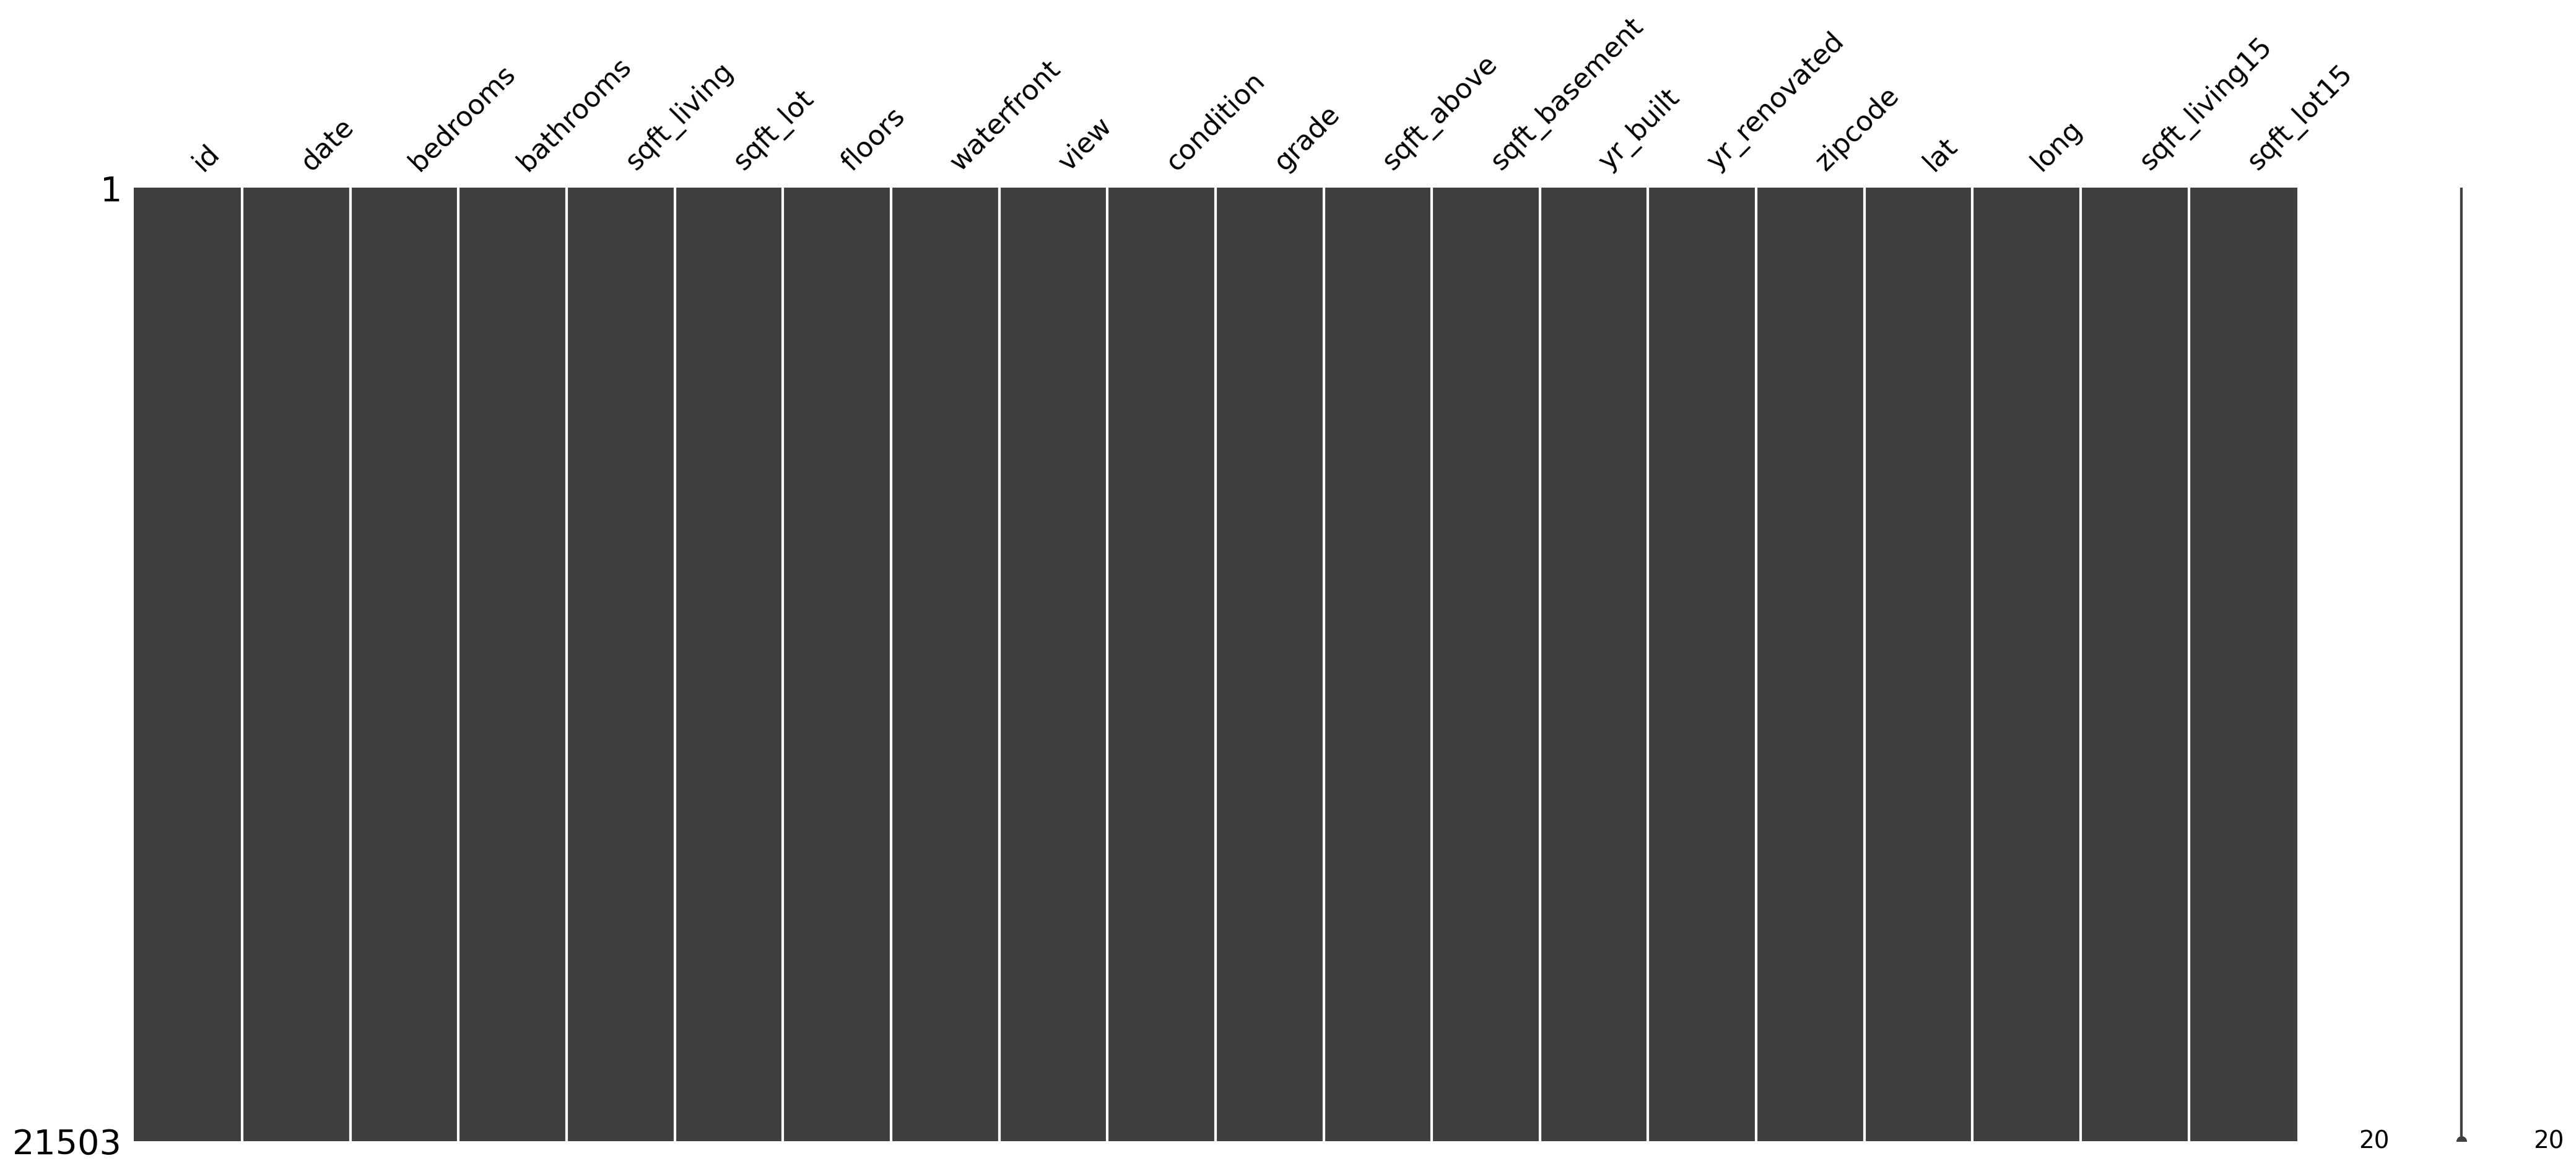

In [7]:
# 결측체크 
msno.matrix(data)

결측 이상 없음 확인 

In [8]:
for c in data.columns:
    print('{} : {}'.format(c, len(data.loc[pd.isnull(data[c]), c].values))) #결측치 없음

id : 0
date : 0
bedrooms : 0
bathrooms : 0
sqft_living : 0
sqft_lot : 0
floors : 0
waterfront : 0
view : 0
condition : 0
grade : 0
sqft_above : 0
sqft_basement : 0
yr_built : 0
yr_renovated : 0
zipcode : 0
lat : 0
long : 0
sqft_living15 : 0
sqft_lot15 : 0


모든 컬럼에 Null값 없음 확인

In [9]:
#Price 컬럼과의 연관을 조사해야 하므로 다시 Train 데이타로 
train = pd.concat((train, y), axis=1)


In [10]:
train.describe()

id      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  15035.000000  15035.000000  15035.000000  15035.000000  1.503500e+04   
mean    7517.000000      3.369139      2.115065   2083.790223  1.529697e+04   
std     4340.374984      0.902721      0.767519    922.134087  4.261282e+04   
min        0.000000      0.000000      0.000000    290.000000  5.200000e+02   
25%     3758.500000      3.000000      1.750000   1430.000000  5.027500e+03   
50%     7517.000000      3.000000      2.250000   1910.000000  7.620000e+03   
75%    11275.500000      4.000000      2.500000   2560.000000  1.069550e+04   
max    15034.000000     10.000000      8.000000  13540.000000  1.651359e+06   

             floors    waterfront          view     condition         grade  \
count  15035.000000  15035.000000  15035.000000  15035.000000  15035.000000   
mean       1.498071      0.007117      0.234253      3.406651      7.660725   
std        0.538522      0.084063      0.763376      0.646505      1.179803   
min        1.000000      0.000000      0.000000      1.000000      1.000000   
25%        1.000000      0.000000      0.000000      3.000000      7.000000   
50%        1.500000      0.000000      0.000000      3.000000      7.000000   
75%        2.000000      0.000000      0.000000      4.000000      8.000000   
max        3.500000      1.000000      4.000000      5.000000     13.000000   

         sqft_above  sqft_basement      yr_built  yr_renovated       zipcode  \
count  15035.000000   15035.000000  15035.000000  15035.000000  15035.000000   
mean    1794.158164     289.632059   1971.100432     83.798936  98078.031726   
std      831.738609     440.663284     29.407612    400.398498     53.297815   
min      290.000000       0.000000   1900.000000      0.000000  98001.000000   
25%     1190.000000       0.000000   1951.000000      0.000000  98033.000000   
50%     1570.000000       0.000000   1975.000000      0.000000  98065.000000   
75%     2230.000000     550.000000   1997.000000      0.000000  98117.000000   
max     9410.000000    4130.000000   2015.000000   2015.000000  98199.000000   

                lat          long  sqft_living15     sqft_lot15         price  
count  15035.000000  15035.000000   15035.000000   15035.000000  1.503500e+04  
mean      47.560721   -122.213677    1992.754772   12823.884935  5.406827e+05  
std        0.138164      0.141294     691.456442   27736.259787  3.715247e+05  
min       47.155900   -122.519000     399.000000     651.000000  7.800000e+04  
25%       47.472700   -122.328000    1490.000000    5100.000000  3.220000e+05  
50%       47.571900   -122.231000    1850.000000    7610.000000  4.500000e+05  
75%       47.678300   -122.126000    2360.000000   10076.000000  6.450000e+05  
max       47.777600   -121.315000    6210.000000  871200.000000  7.700000e+06

표준편차가 너무 크고 수치가 각기 다르므로 Log Scaling을 해서 Normalization 하자

# 2. Normalize - Scale 조정
* 주요 Columns Scale 조정
* Price Scale 조정

## 주요 Feature Scale 조정

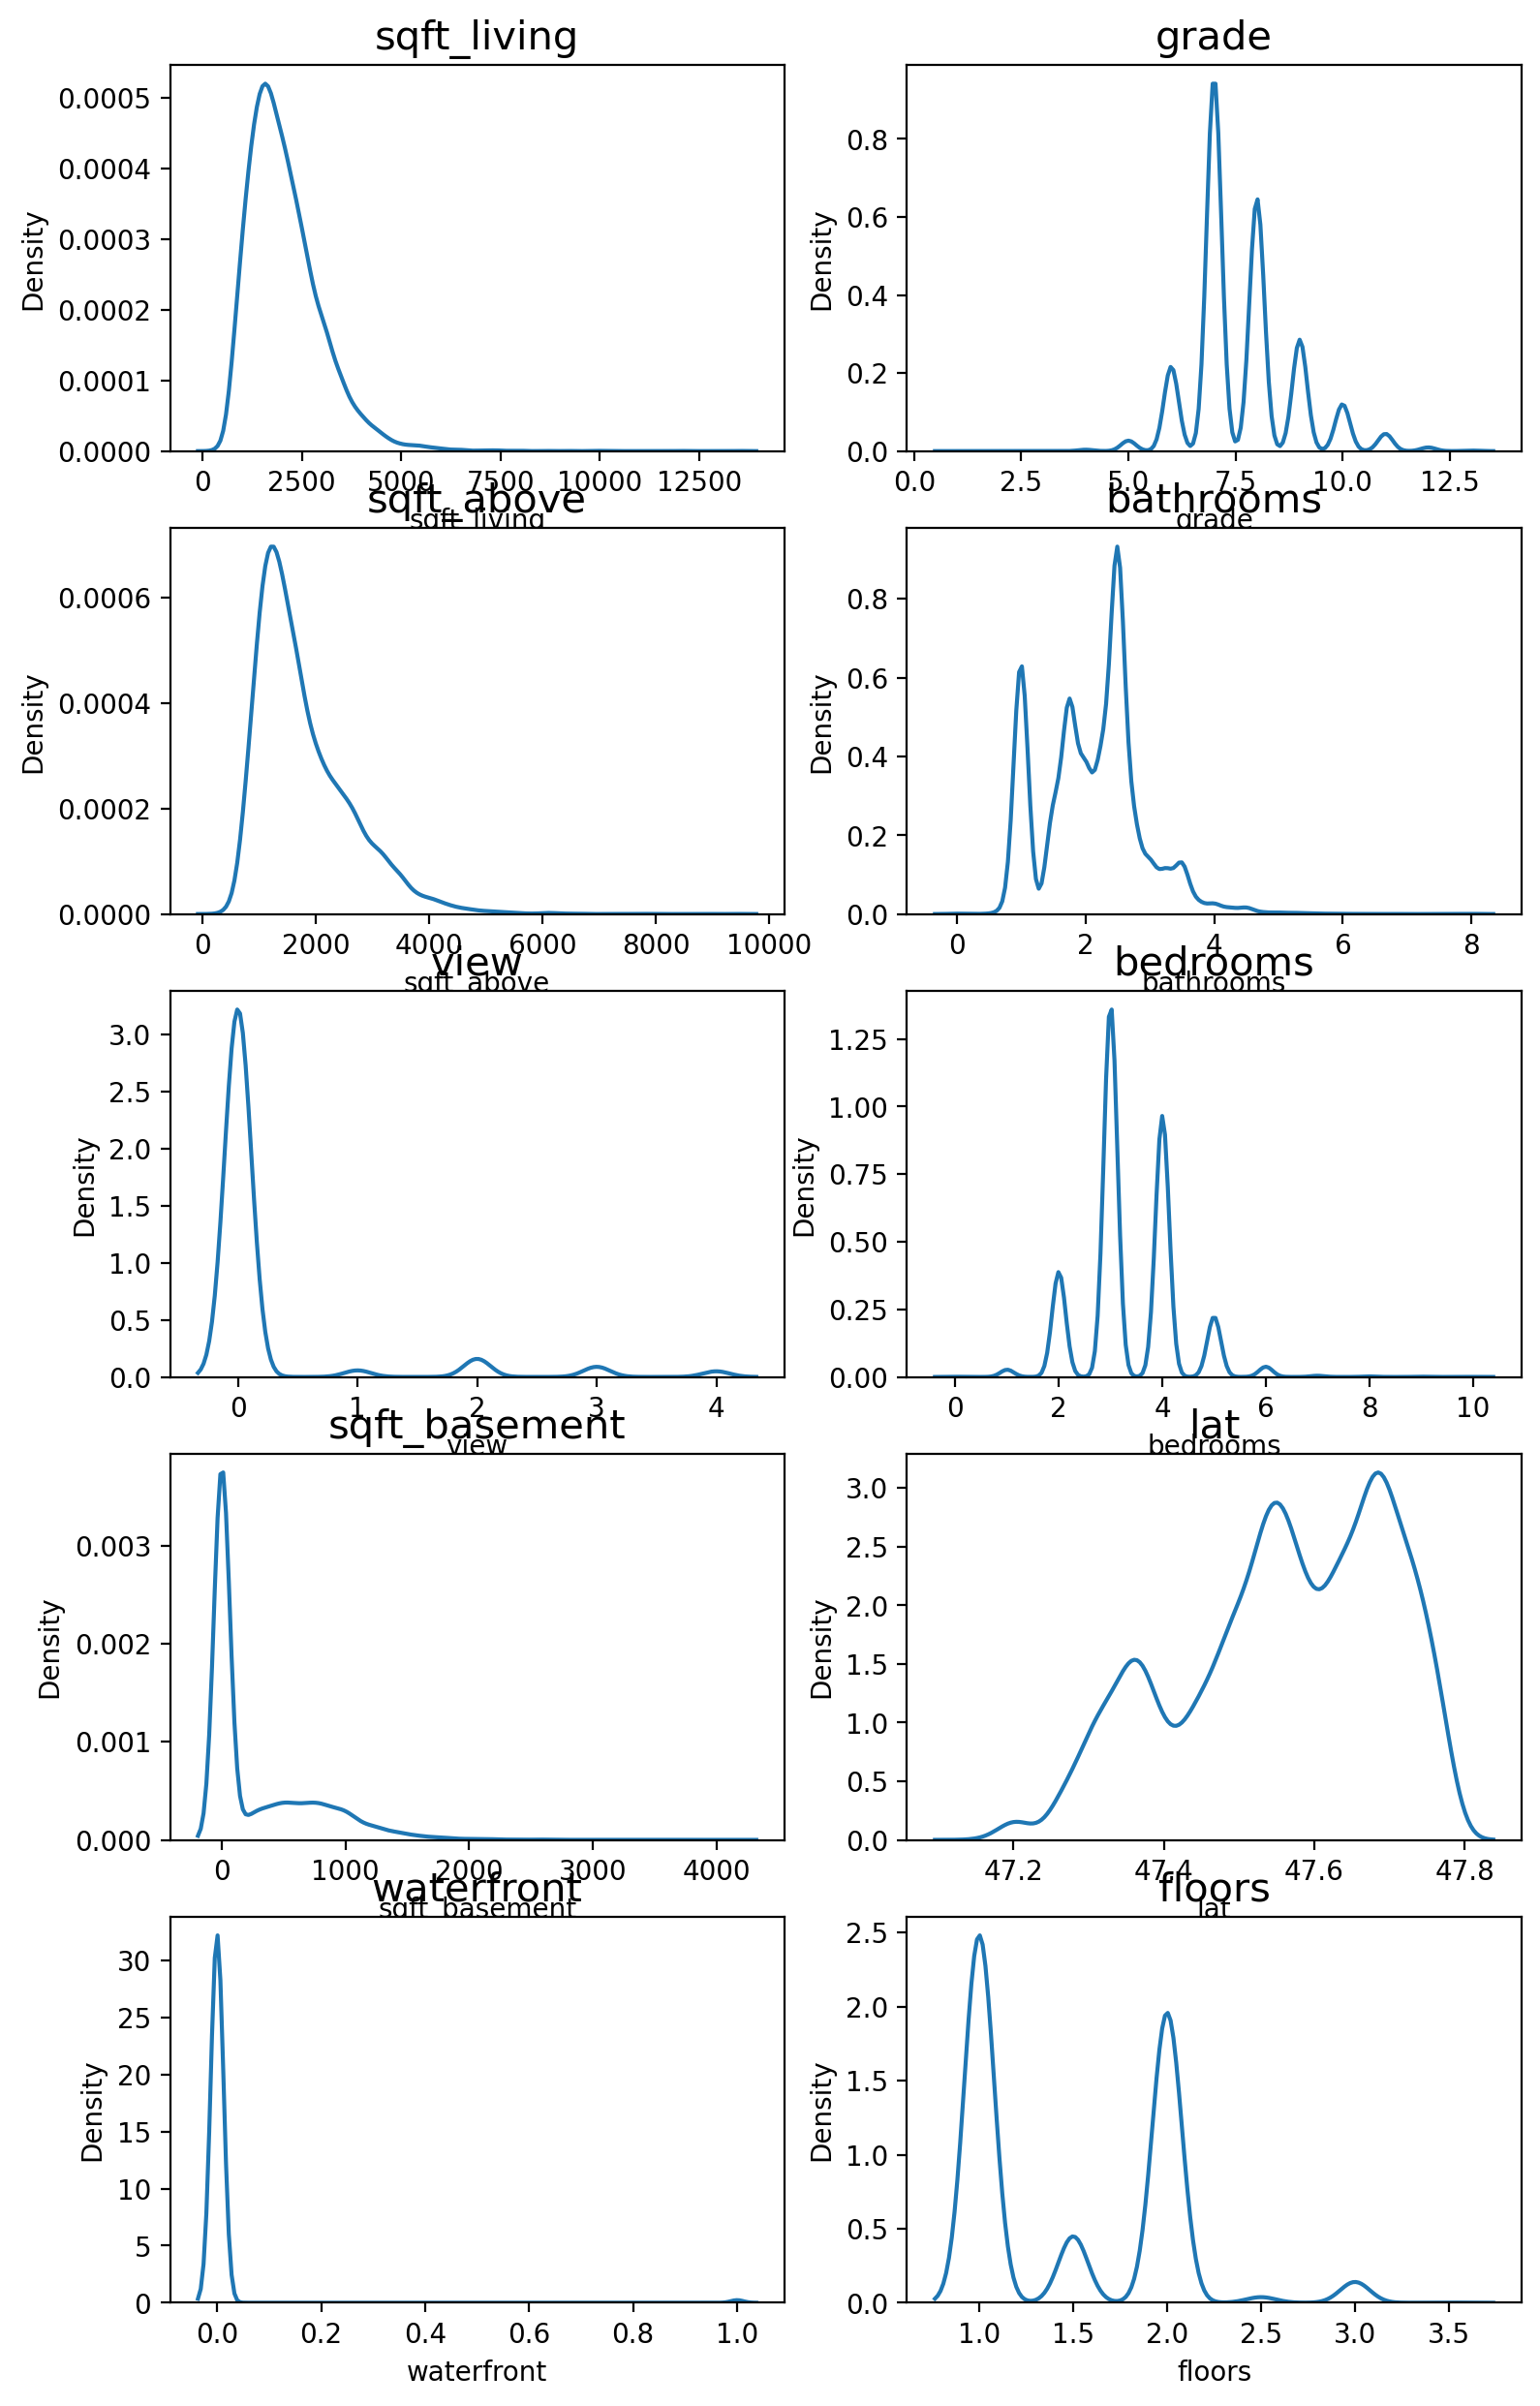

In [11]:
skew_columns = ['sqft_living','grade','sqft_above','bathrooms','view','bedrooms','sqft_basement','lat','waterfront','floors']

fig, ax = plt.subplots(5, 2, figsize=(9, 15))

count = 0
for row in range(5):
    for col in range(2):
        if count == 10:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col] )
        ax[row][col].set_title(skew_columns[count], fontsize=15)
        count += 1

그래프들이 치우친 것이 보인다. 이것을 log로 스케일링 해주자. 

In [12]:
# 스케일을 조정할 대는 Train과 Test 모두 

skew_columns = ['sqft_living','grade','sqft_above','bathrooms','view','bedrooms','sqft_basement','lat','waterfront','floors']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)

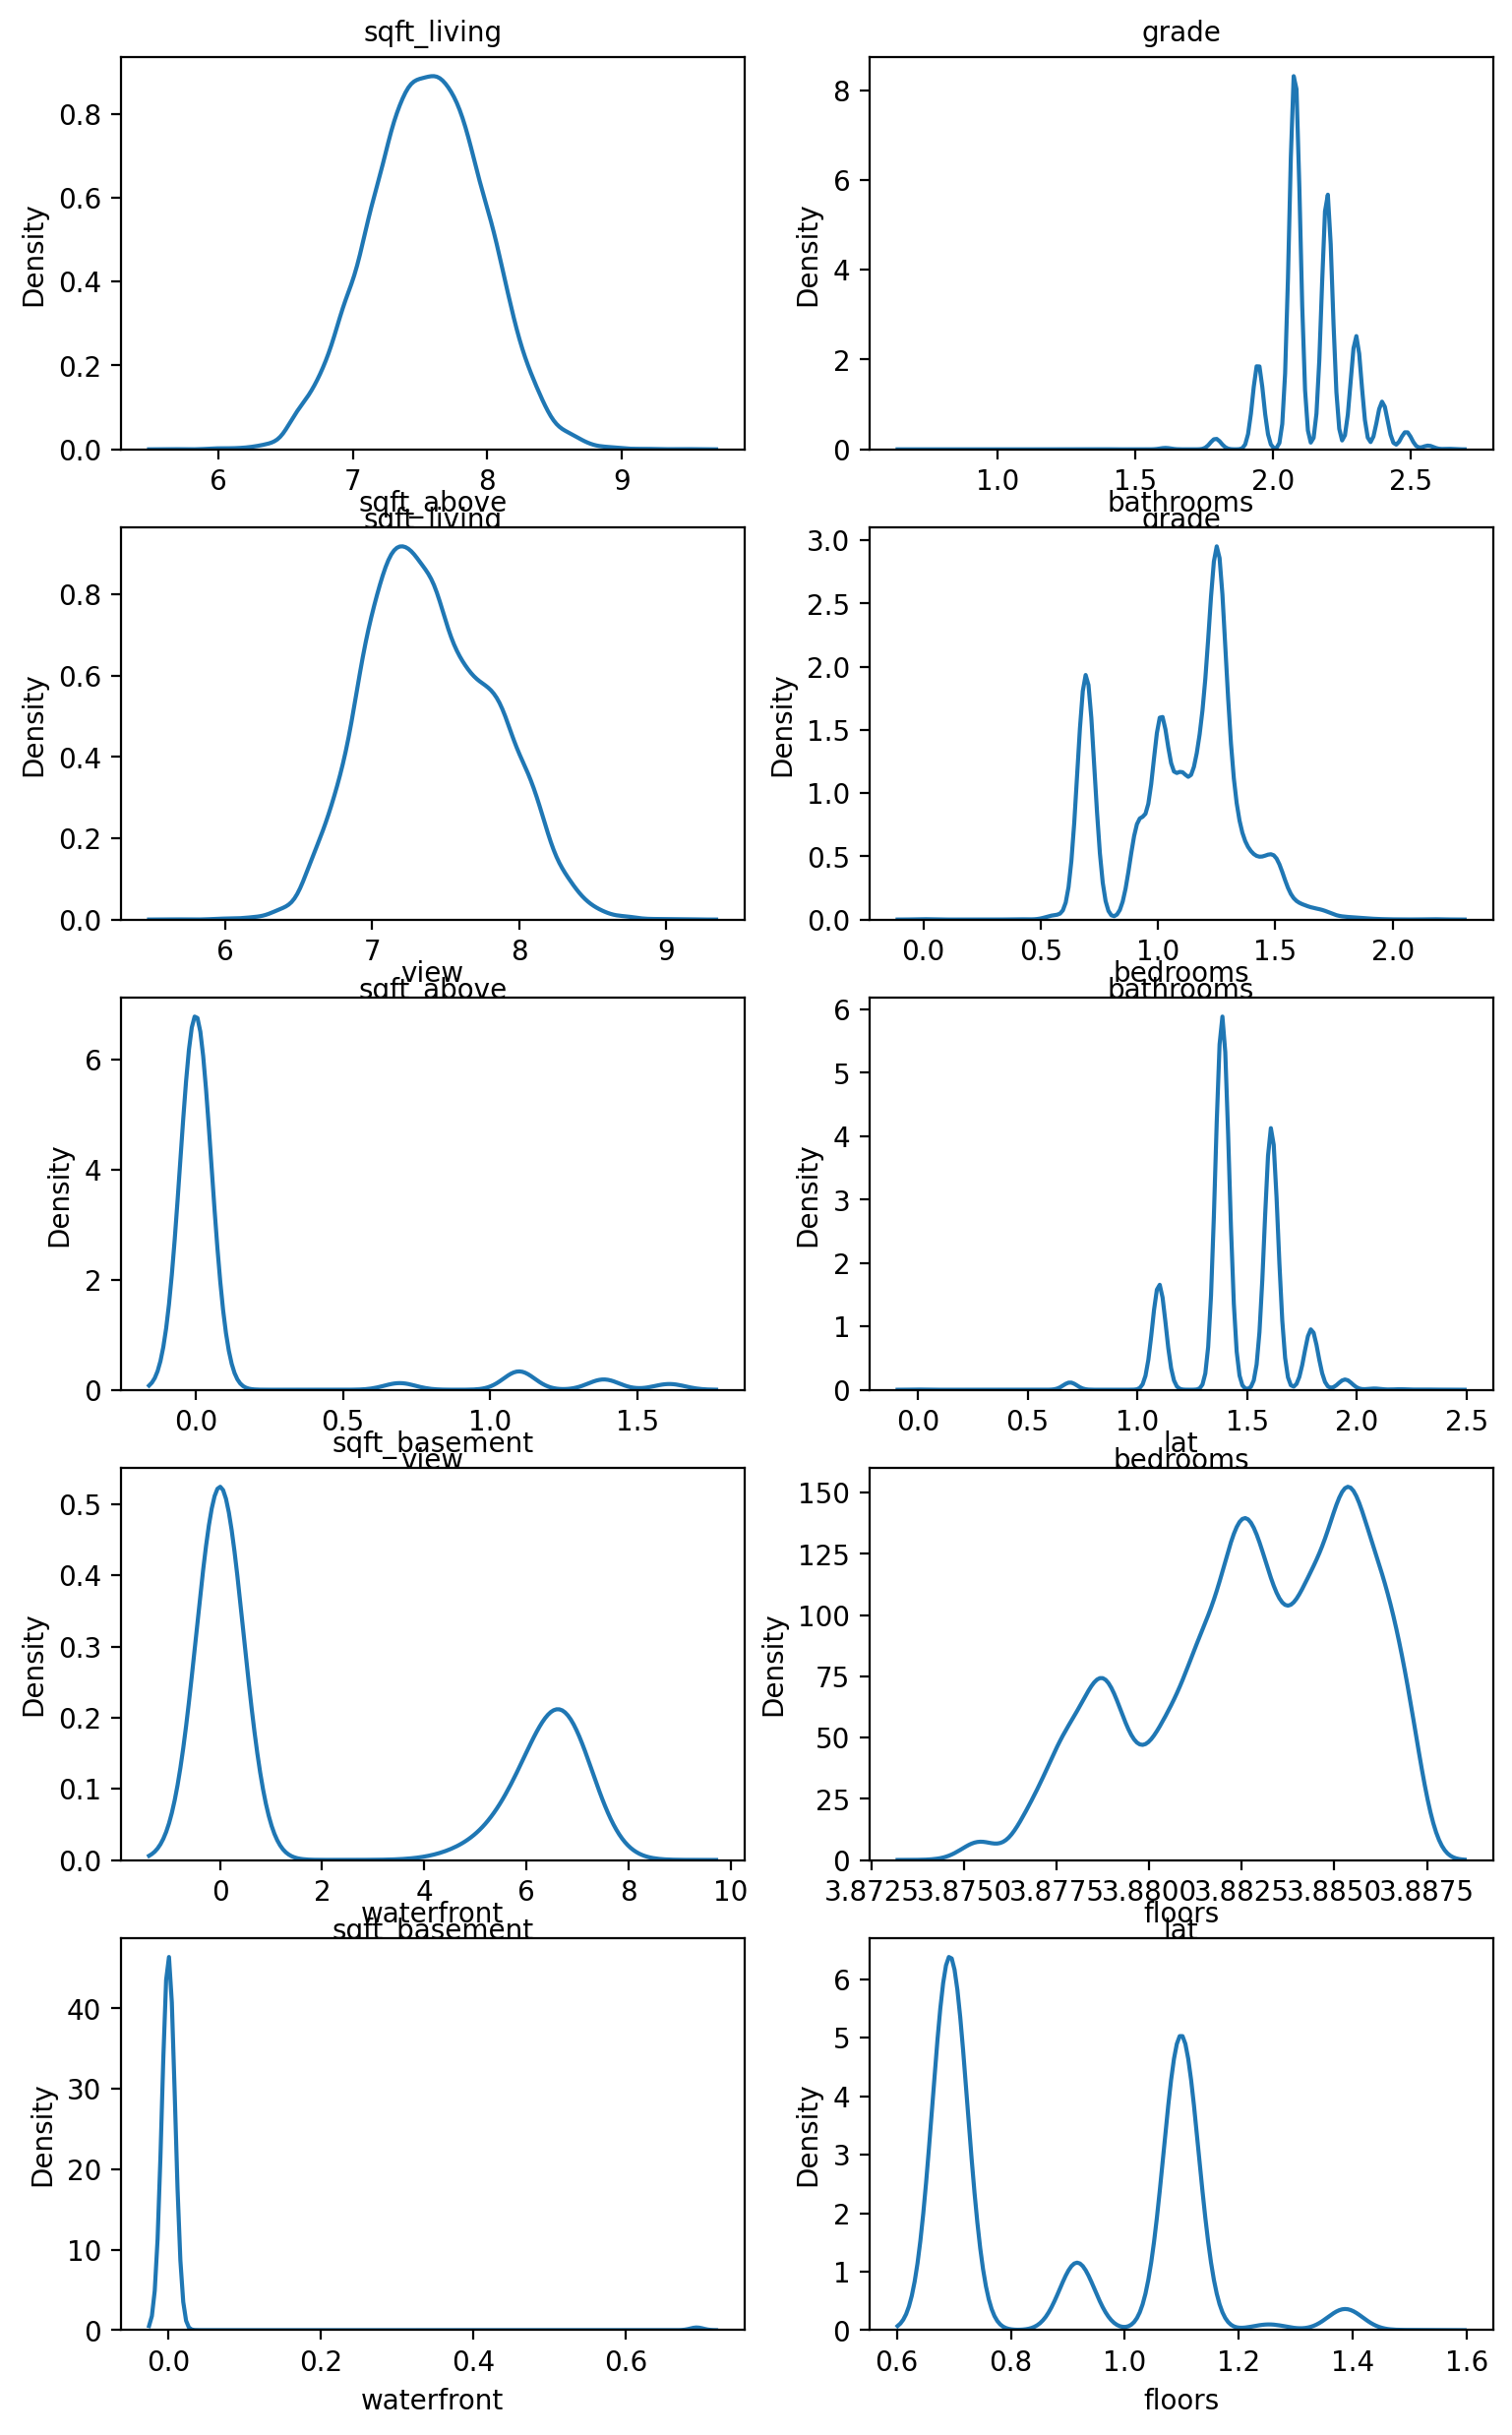

In [13]:
skew_columns = ['sqft_living','grade','sqft_above','bathrooms','view','bedrooms','sqft_basement','lat','waterfront','floors']

fig, ax = plt.subplots(5, 2, figsize=(9, 15))

count = 0
for row in range(5):
    for col in range(2):
        if count == 10:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col] )
        ax[row][col].set_title(skew_columns[count], fontsize=10)
        count += 1

모두 예쁘게 정규분포의 모양으로 Normalize되었다.

In [14]:
# Price는 따로 
train['price']= np.log1p(train['price'])


# 3.전체 Freature에 대한 분포 조사(Train)

## (3-1) 모든 feature 상관계수 

In [15]:
#컬럼간에 Price와의 상관 관계조사
corr_df= train[[ 'price','date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15']]
corr_df.corr()


price  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
price          1.000000  0.356086   0.533806     0.677383  0.108946  0.326308   
bedrooms       0.356086  1.000000   0.539349     0.654434  0.032578  0.210659   
bathrooms      0.533806  0.539349   1.000000     0.766867  0.079660  0.520106   
sqft_living    0.677383  0.654434   0.766867     1.000000  0.152306  0.394396   
sqft_lot       0.108946  0.032578   0.079660     0.152306  1.000000  0.005465   
floors         0.326308  0.210659   0.520106     0.394396  0.005465  1.000000   
waterfront     0.172580 -0.008997   0.063510     0.083036  0.025584  0.031062   
view           0.344926  0.077783   0.165191     0.242662  0.079820  0.029048   
condition      0.042947  0.036453  -0.117850    -0.044443 -0.002099 -0.259820   
grade          0.697295  0.402109   0.663856     0.745830  0.109459  0.473379   
sqft_above     0.591185  0.549797   0.695192     0.867473  0.163799  0.574079   
sqft_basement  0.231982  0.192605   0.187497     0.277304 -0.025039 -0.267972   
yr_built       0.076293  0.184313   0.527937     0.348704  0.058686  0.483546   
yr_renovated   0.127533  0.015862   0.058250     0.058676 -0.001451  0.012769   
zipcode       -0.039195 -0.178626  -0.224796    -0.223746 -0.127709 -0.067421   
lat            0.444711 -0.023407   0.008221     0.036544 -0.082341  0.041846   
long           0.054362  0.150666   0.240560     0.260941  0.227451  0.141850   
sqft_living15  0.621800  0.411506   0.563684     0.737799  0.147562  0.304174   
sqft_lot15     0.096976  0.027193   0.079700     0.160507  0.728458 -0.005942   

               waterfront      view  condition     grade  sqft_above  \
price            0.172580  0.344926   0.042947  0.697295    0.591185   
bedrooms        -0.008997  0.077783   0.036453  0.402109    0.549797   
bathrooms        0.063510  0.165191  -0.117850  0.663856    0.695192   
sqft_living      0.083036  0.242662  -0.044443  0.745830    0.867473   
sqft_lot         0.025584  0.079820  -0.002099  0.109459    0.163799   
floors           0.031062  0.029048  -0.259820  0.473379    0.574079   
waterfront       1.000000  0.334761   0.011613  0.079114    0.067640   
view             0.334761  1.000000   0.047938  0.231937    0.155480   
condition        0.011613  0.047938   1.000000 -0.141000   -0.144170   
grade            0.079114  0.231937  -0.141000  1.000000    0.742321   
sqft_above       0.067640  0.155480  -0.144170  0.742321    1.000000   
sqft_basement    0.040272  0.201120   0.150613  0.073019   -0.192870   
yr_built        -0.026523 -0.066454  -0.366590  0.452937    0.449655   
yr_renovated     0.104168  0.103493  -0.062342  0.029509    0.032934   
zipcode          0.028632  0.092607   0.001106 -0.187028   -0.287100   
lat             -0.014718  0.006291  -0.015986  0.114112   -0.018428   
long            -0.037922 -0.077633  -0.110742  0.196896    0.363379   
sqft_living15    0.091810  0.278604  -0.091407  0.696277    0.716916   
sqft_lot15       0.028255  0.076261  -0.003873  0.108966    0.173399   

               sqft_basement  yr_built  yr_renovated   zipcode       lat  \
price               0.231982  0.076293      0.127533 -0.039195  0.444711   
bedrooms            0.192605  0.184313      0.015862 -0.178626 -0.023407   
bathrooms           0.187497  0.527937      0.058250 -0.224796  0.008221   
sqft_living         0.277304  0.348704      0.058676 -0.223746  0.036544   
sqft_lot           -0.025039  0.058686     -0.001451 -0.127709 -0.082341   
floors             -0.267972  0.483546      0.012769 -0.067421  0.041846   
waterfront          0.040272 -0.026523      0.104168  0.028632 -0.014718   
view                0.201120 -0.066454      0.103493  0.092607  0.006291   
condition           0.150613 -0.366590     -0.062342  0.001106 -0.015986   
grade               0.073019  0.452937      0.029509 -0.187028  0.114112   
sqft_above         -0.192870  0.449655      0.032934 -0.287100 -0.018428   
sqft_basement       1.000000 -0.170504      

## (3-2) 상관계수 Top 10 feature

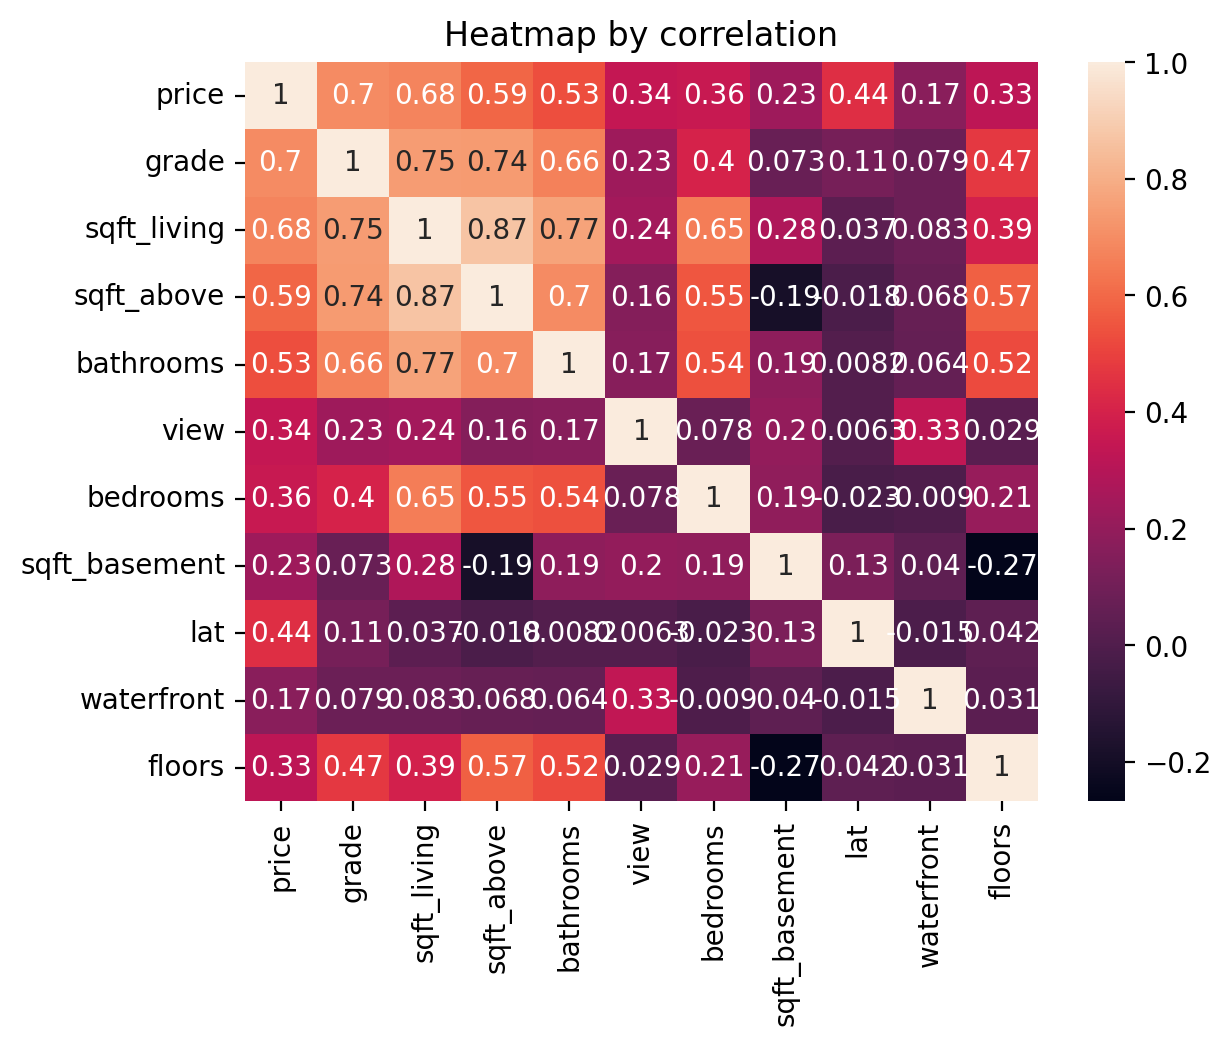

<Figure size 1500x1500 with 0 Axes>

In [16]:
#상관계수가 높은 순서로 10개  heatmap
corr_df = train[['price','grade','sqft_living','sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat', 'waterfront',  'floors']]

sns.heatmap(data=corr_df.corr(), annot=True)
plt.title('Heatmap by correlation')
plt.figure(figsize=(15,15))
plt.show()


상관계수가 높은 순서대로 Price에 영향을 주는 정도가 결정된다. 상관계수가 높은 순서의 feature 들부터 개별 분포를 하나씩 확인하며 이상치 여부를 확인하자. 

# 4.데이타 전처리
* Columns 에 대한 전처리 : Colunm 변환, 새로운 컬럼 생성등 (Train, Test 모두)
* Rows 이상치 찾아 처리 : 특이값 삭제(Train 데이타만)



## (4-1) Columns 에 대한 전처리 : Colunm 변환, 새로운 컬럼 생성등 (Train, Test 모두)

In [17]:
train['is_renovated'] = train['yr_renovated'].apply(lambda x: 0 if x==0 else 1)
train['date'] = train['date'].apply(lambda i:i[:6]).astype(int) 
#train['sqft_living'] = train['sqft_living15']
#train['sqft_price'] = round(train['sqft_living']/train['price'],2)

test['is_renovated'] = test['yr_renovated'].apply(lambda x: 0 if x==0 else 1)
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int) 
#test['sqft_living'] = test['sqft_living15']
#test['sqft_price'] = round(test['sqft_living']/train['price'],2)

## (4-2) Rows 이상치 찾아 처리 (Train 데이타만)

price에 대한 상관계수 TOP10의 Feature 하나하나 이상치, 특이값이 있는지 조사해서 row를 삭제한다.   
'sqft_living',  'grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat', 'waterfront',  'floors'

In [18]:
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight

    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight

    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

## (4-3) price 에 대한 이상치 체크

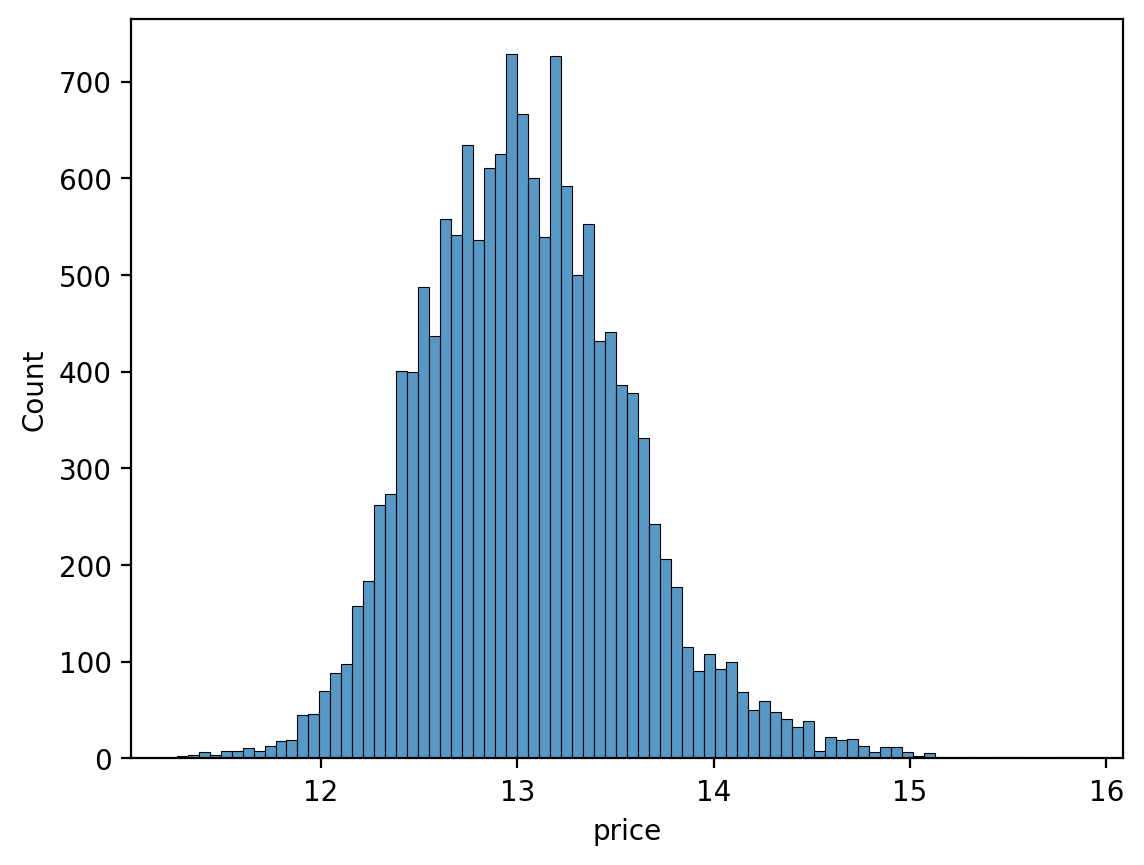

In [19]:

sns.histplot(data=train, x='price')
plt.show()

In [20]:
#train['price'].min(),train['price'].max()
oulier_idx_price = get_outlier(df=train, column='price', weight=2.5)

In [21]:
train.iloc[oulier_idx_price]['price']

842      15.446867
947      15.483218
1045     15.492607
1499     15.163584
1882     15.319588
2775     15.770310
3134     15.532906
4957     15.150512
5108     15.856731
6469     15.744856
11364    15.126543
Name: price, dtype: float64

## (4-4) sqft_living 이상치 체크

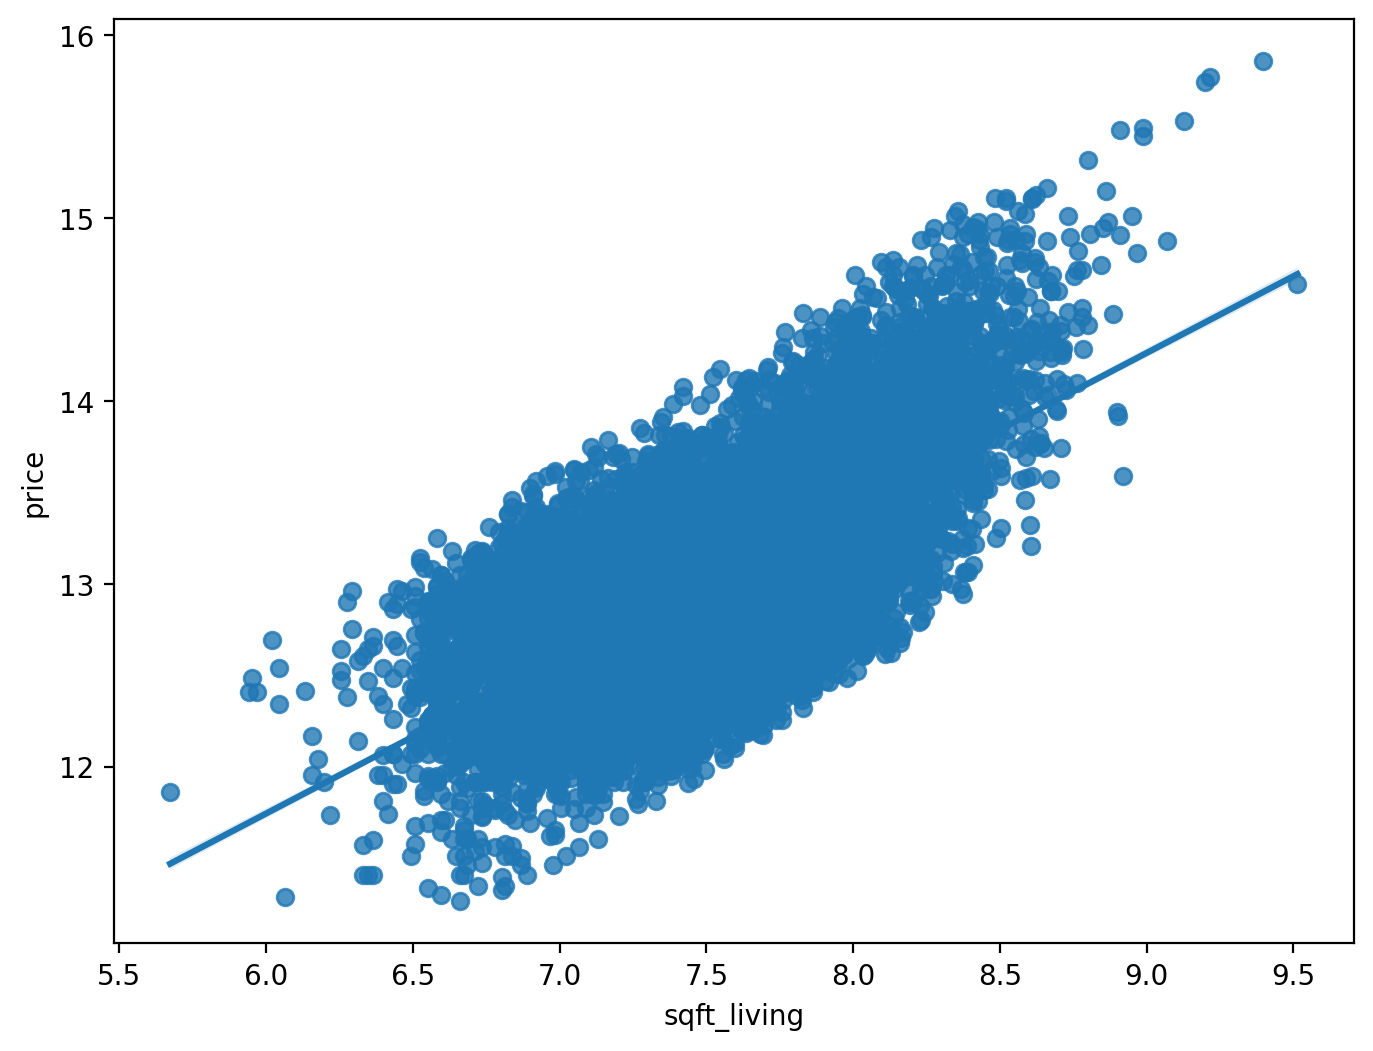

In [22]:
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [23]:
oulier_idx_sl = get_outlier(df=train, column='sqft_living', weight=2.5)
#train.drop(oulier_idx, axis=0, inplace=True)

In [24]:
train.iloc[oulier_idx_sl][['price','sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat', 'waterfront',  'floors']]

price  sqft_living     grade  sqft_above  bathrooms      view  \
5108   15.856731     9.396903  2.639057    9.056140   2.197225  1.386294   
8912   14.639686     9.513477  2.564949    9.149634   2.197225  1.609438   
13522  11.863589     5.673323  0.693147    5.673323   0.000000  0.000000   

       bedrooms  sqft_basement       lat  waterfront    floors  
5108   1.945910       8.155075  3.884237         0.0  1.252763  
8912   2.079442       8.326275  3.885011         0.0  1.386294  
13522  0.000000       0.000000  3.882199         0.0  0.693147

## (4-5) grade에 대한 이상치 체크

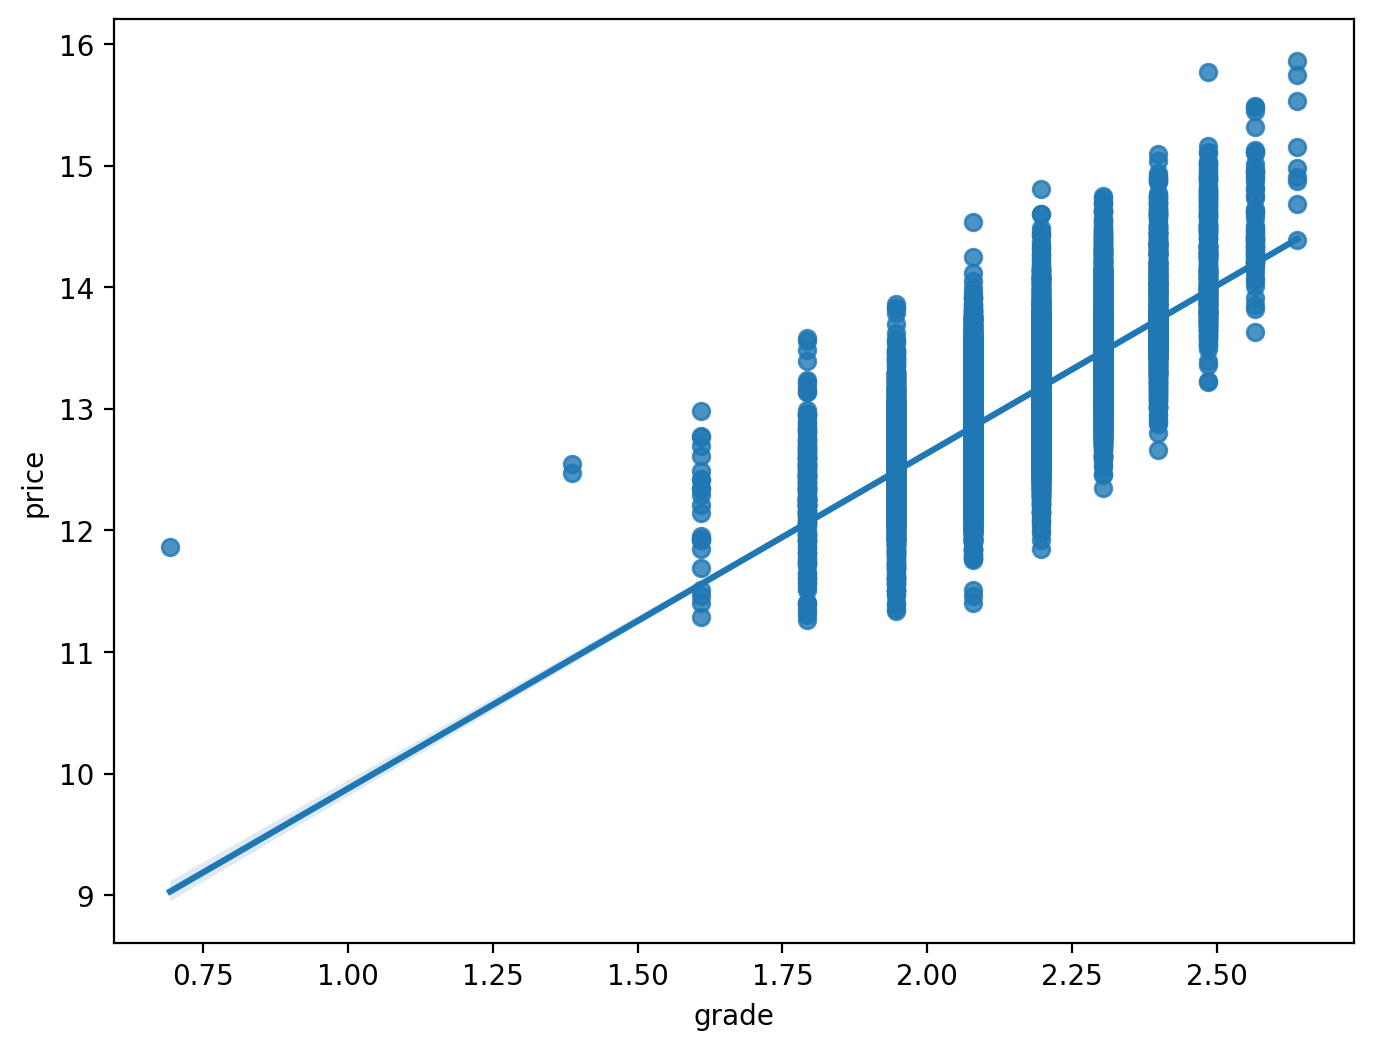

In [25]:
#grade
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='grade', y="price", data=data)

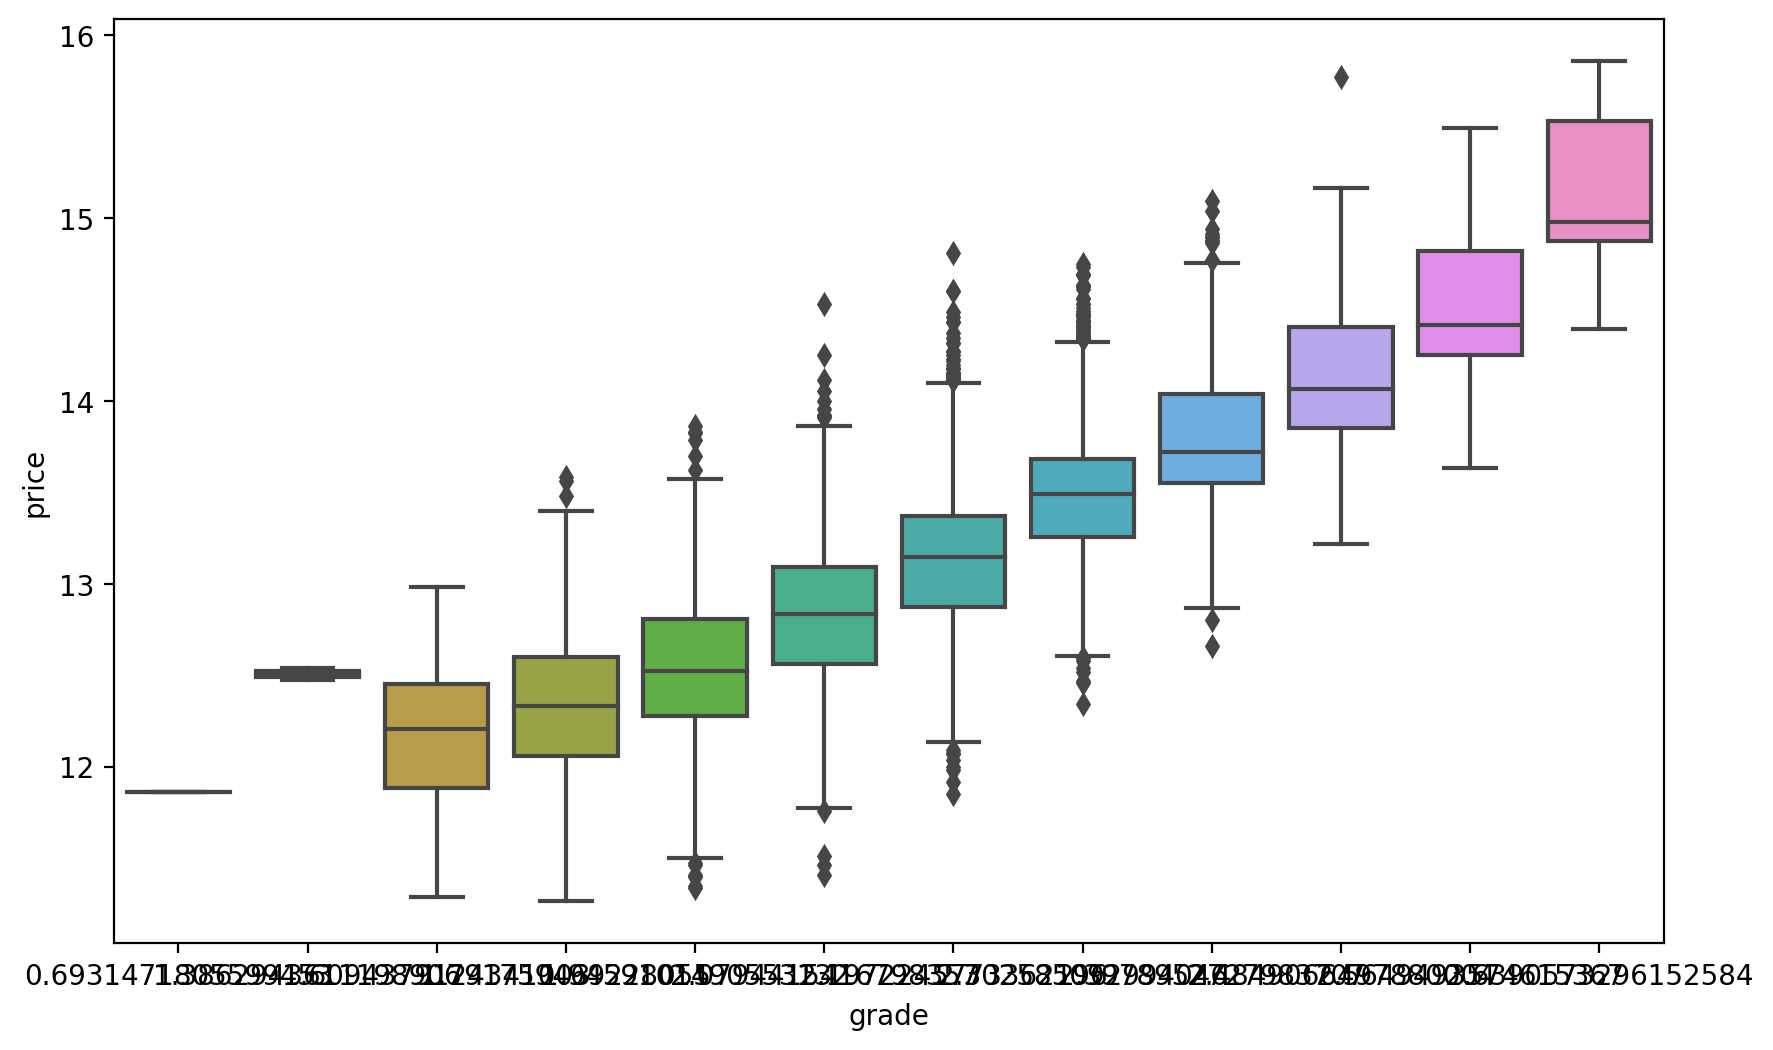

In [26]:
# grade
plt.figure(figsize=(10,6))
sns.boxplot(x='grade', y='price', data=train)
plt.show()

In [27]:
train['grade'].unique()

array([2.07944154, 1.94591015, 2.19722458, 2.30258509, 2.39789527,
       2.48490665, 2.56494936, 1.79175947, 1.60943791, 1.38629436,
       2.63905733, 0.69314718])

In [28]:
train[(train['grade']<=1.5) ].index  # 2302, 4123, 13522

Int64Index([2302, 4123, 13522], dtype='int64')

In [29]:
oulier_idx_grade = get_outlier(df=train, column='grade', weight=4.0)
oulier_idx_grade

Int64Index([2302, 4123, 13522], dtype='int64')

In [30]:
train.iloc[oulier_idx_grade]['grade']

2302     1.386294
4123     1.386294
13522    0.693147
Name: grade, dtype: float64

## (4-6) sqft_above 이상치 체크

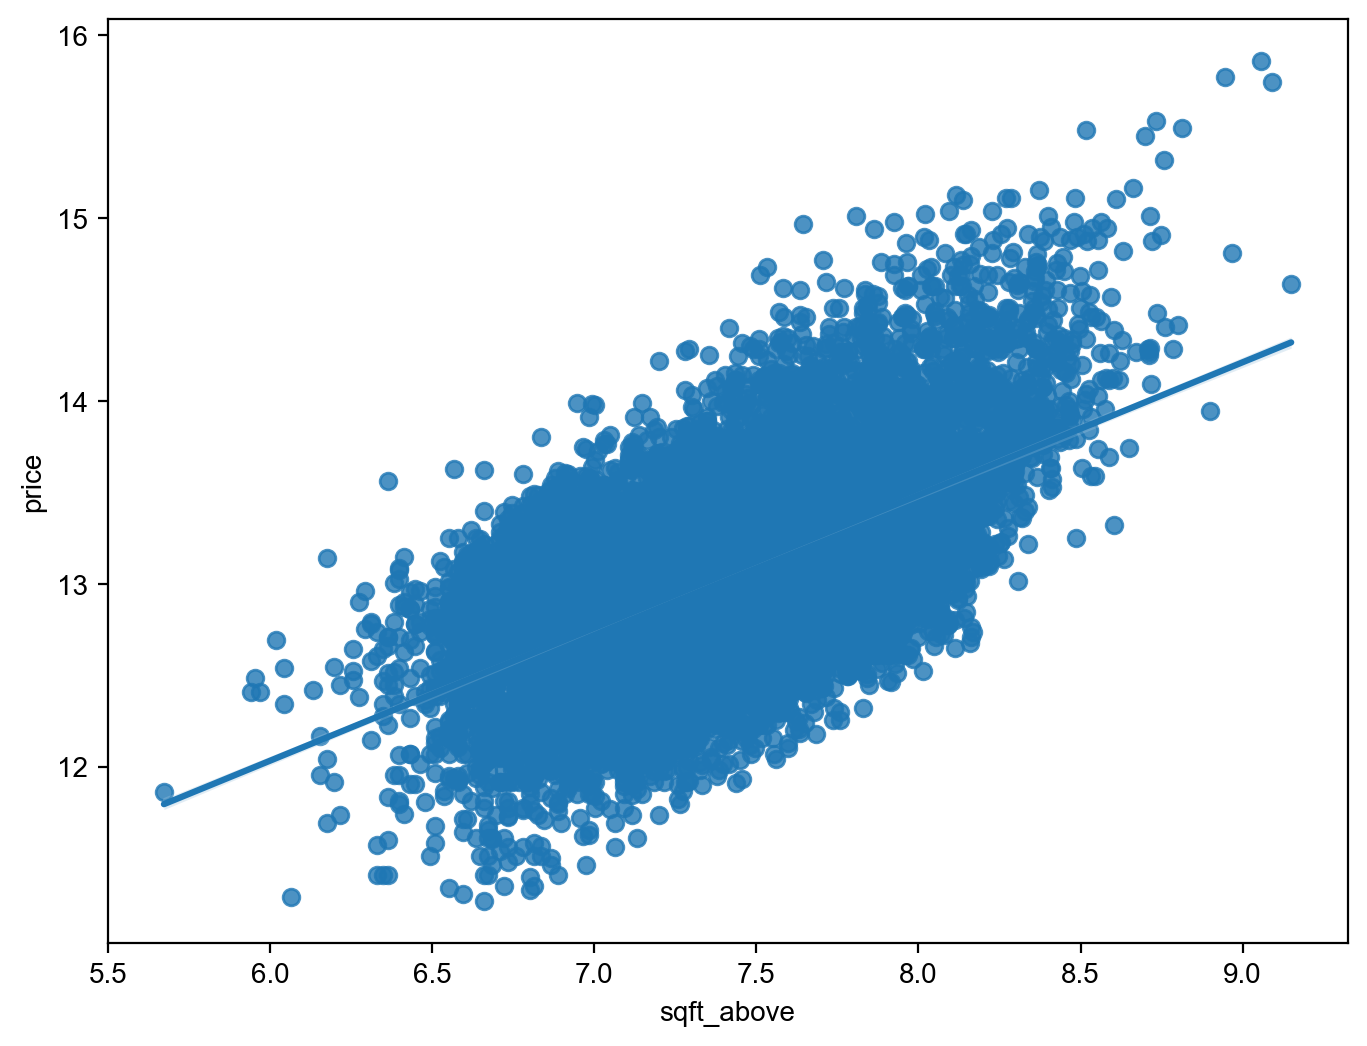

In [31]:
# sqft_above
data = pd.concat([train['price'], train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
sns.set_style ('whitegrid')
fig = sns.regplot(x='sqft_above', y="price", data=data)

In [32]:
oulier_idx_sa = get_outlier(df=train, column='sqft_above', weight=1.9)
oulier_idx_sa

Int64Index([2775, 5108, 6469, 8912, 13522, 13809], dtype='int64')

In [33]:
train.iloc[oulier_idx_sa][['price','sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat', 'waterfront',  'floors']]

price  sqft_living     grade  sqft_above  bathrooms      view  \
2775   15.770310     9.214432  2.484907    8.946505   1.704748  1.098612   
5108   15.856731     9.396903  2.639057    9.056140   2.197225  1.386294   
6469   15.744856     9.199381  2.639057    9.089415   2.169054  1.609438   
8912   14.639686     9.513477  2.564949    9.149634   2.197225  1.609438   
13522  11.863589     5.673323  0.693147    5.673323   0.000000  0.000000   
13809  14.808763     8.968396  2.564949    8.968396   1.609438  0.000000   

       bedrooms  sqft_basement       lat  waterfront    floors  
2775   1.791759       7.766841  3.884652    0.693147  1.098612  
5108   1.945910       8.155075  3.884237    0.000000  1.252763  
6469   1.945910       6.938284  3.884251    0.000000  1.098612  
8912   2.079442       8.326275  3.885011    0.000000  1.386294  
13522  0.000000       0.000000  3.882199    0.000000  0.693147  
13809  1.609438       0.000000  3.882401    0.000000  1.098612

## (4-7) bathrooms 이상치 체크

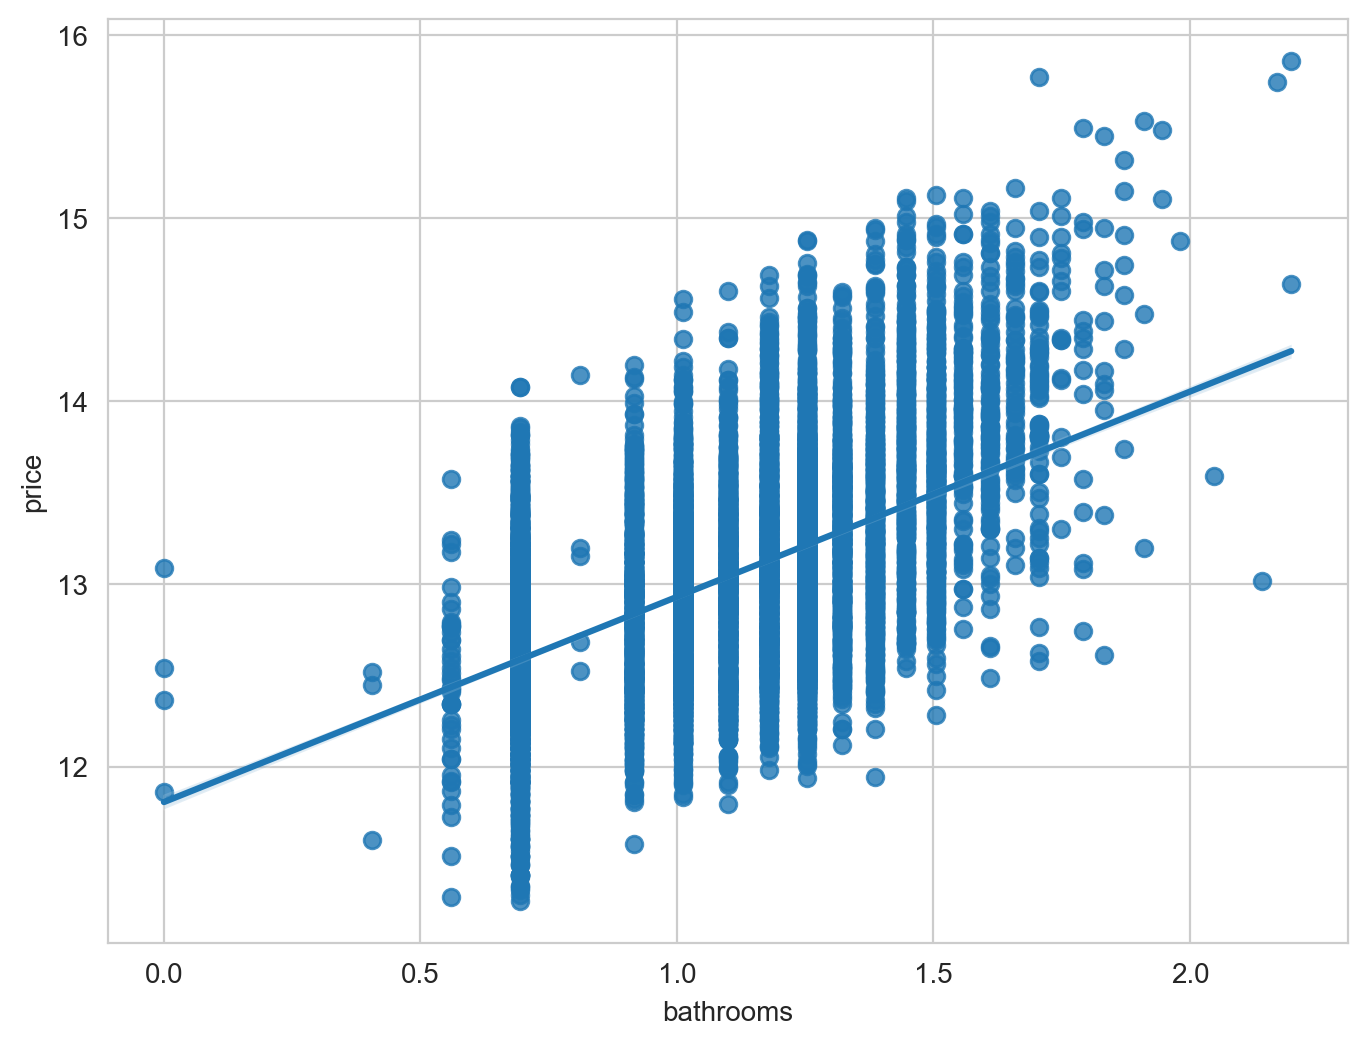

In [34]:

#'sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat'
# bathrooms

data = pd.concat([train['price'], train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
sns.set_style ('whitegrid')
fig = sns.regplot(x='bathrooms', y="price", data=data)



In [35]:
oulier_idx_bath = get_outlier(df=train, column='bathrooms', weight=4.0)
oulier_idx_bath

Int64Index([4123, 6885, 7322, 13522], dtype='int64')

In [36]:
train.iloc[oulier_idx_bath][['price','sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat', 'waterfront', 'floors']]

price  sqft_living     grade  sqft_above  bathrooms  view  \
4123   12.542548     6.398595  1.386294    6.398595        0.0   0.0   
6885   12.367345     7.293698  2.079442    7.293698        0.0   0.0   
7322   13.089842     6.538140  2.079442    6.538140        0.0   0.0   
13522  11.863589     5.673323  0.693147    5.673323        0.0   0.0   

       bedrooms  sqft_basement       lat  waterfront    floors  
4123   0.693147            0.0  3.882215         0.0  0.693147  
6885   0.000000            0.0  3.882110         0.0  1.098612  
7322   0.693147            0.0  3.884506         0.0  0.693147  
13522  0.000000            0.0  3.882199         0.0  0.693147

## (4-8) view 이상치 체크

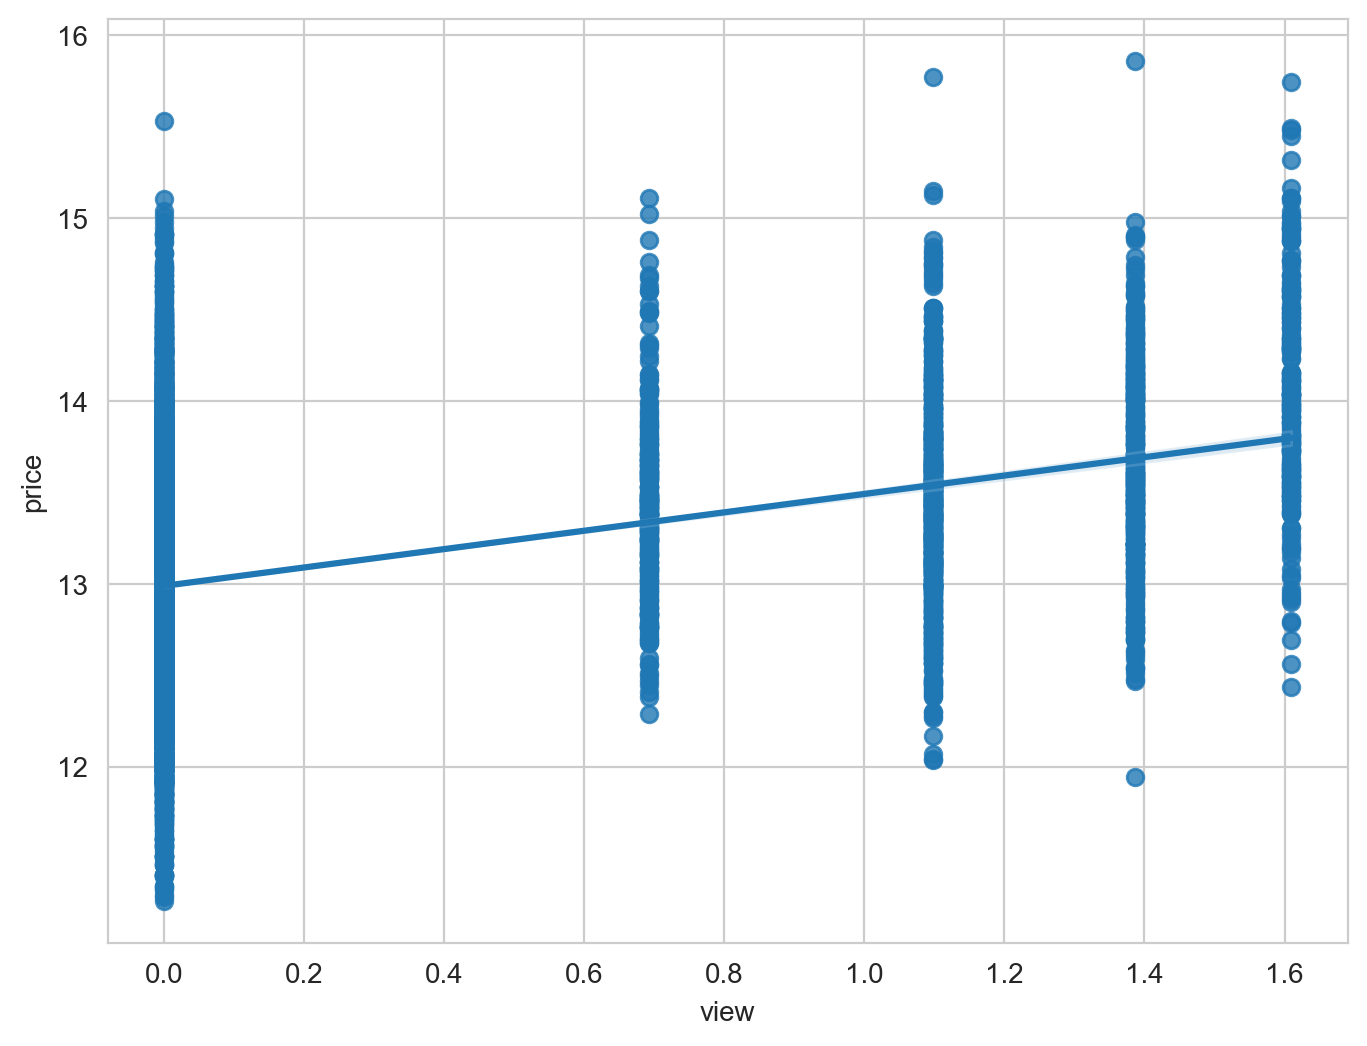

In [37]:

#'sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat'
# bathrooms
feature_is='view'
data = pd.concat([train['price'], train['view']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
sns.set_style ('whitegrid')
fig = sns.regplot(x='view', y="price", data=data)


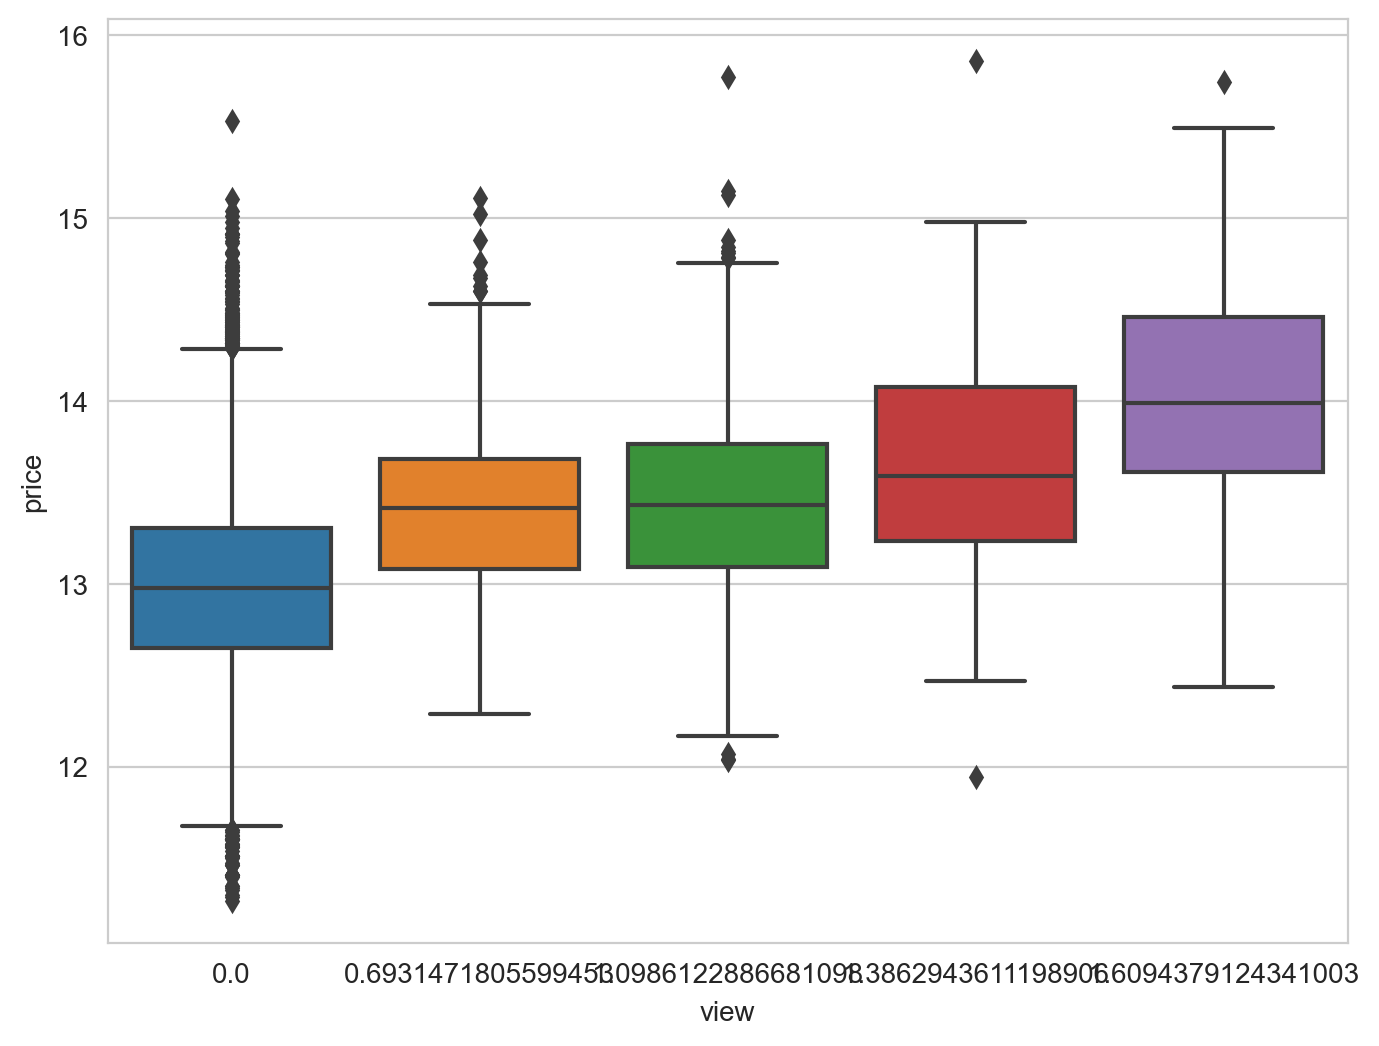

In [38]:
#'sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat'
# bathrooms
data = pd.concat([train['price'], train['view']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
sns.set_style ('whitegrid')
fig = sns.boxplot(x='view', y="price", data=data)

In [39]:
get_outlier(df=train, column='view', weight=10.0)  # 이것으로는 잡을 수 없다.  정규분포 형태가 아니라서


Int64Index([   10,    16,    39,    40,    67,    76,    77,    82,    84,
               98,
            ...
            14886, 14894, 14895, 14954, 14972, 14980, 14981, 14993, 15012,
            15022],
           dtype='int64', length=1487)

In [40]:
train['view'].unique()

array([0.        , 1.38629436, 1.60943791, 1.09861229, 0.69314718])

In [41]:
train[ (train['price']>=15.5)]

id    date  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
2775  2775  201406  1.791759   1.704748     9.214432     37325  1.098612   
3134  3134  201408  1.791759   1.909543     9.127067     35069  1.098612   
5108  5108  201410  1.945910   2.197225     9.396903     27600  1.252763   
6469  6469  201409  1.945910   2.169054     9.199381     31374  1.098612   

      waterfront      view  condition  ...  sqft_basement  yr_built  \
2775    0.693147  1.098612          3  ...       7.766841      1940   
3134    0.000000  0.000000          3  ...       8.006701      2001   
5108    0.000000  1.386294          4  ...       8.155075      1910   
6469    0.000000  1.609438          3  ...       6.938284      2001   

      yr_renovated  zipcode       lat     long  sqft_living15  sqft_lot15  \
2775          2001    98004  3.884652 -122.214           3930       25449   
3134             0    98039  3.884218 -122.233           3560       24345   
5108          1987    98102  3.884237 -122.323           3940        8800   
6469             0    98039  3.884251 -122.240           4540       42730   

          price  is_renovated  
2775  15.770310             1  
3134  15.532906             0  
5108  15.856731             1  
6469  15.744856             0  

[4 rows x 22 columns]

In [42]:
train[ (train['view']>=1.3) &(train['price']<=12)]

id    date  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
3395  3395  201409  1.098612   0.693147     6.947937     20524  0.693147   

      waterfront      view  condition  ...  sqft_basement  yr_built  \
3395         0.0  1.386294          3  ...            0.0      1949   

      yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
3395          1989    98014  3.88564 -121.875           1880       38996   

          price  is_renovated  
3395  11.944714             1  

[1 rows x 22 columns]

In [43]:
oulier_idx_view = [3134]
oulier_idx_view

[3134]

In [44]:
train.iloc[oulier_idx_view][['price','sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat', 'waterfront', 'floors']]

price  sqft_living     grade  sqft_above  bathrooms  view  bedrooms  \
3134  15.532906     9.127067  2.639057    8.732466   1.909543   0.0  1.791759   

      sqft_basement       lat  waterfront    floors  
3134       8.006701  3.884218         0.0  1.098612

View가 좋아서 집값이 높은 것은 당연하므로 View가 0인데 집값이 높은 것만 이상건으로 간주하여 삭제한다

# (4-9) bedrooms 이상치 체크

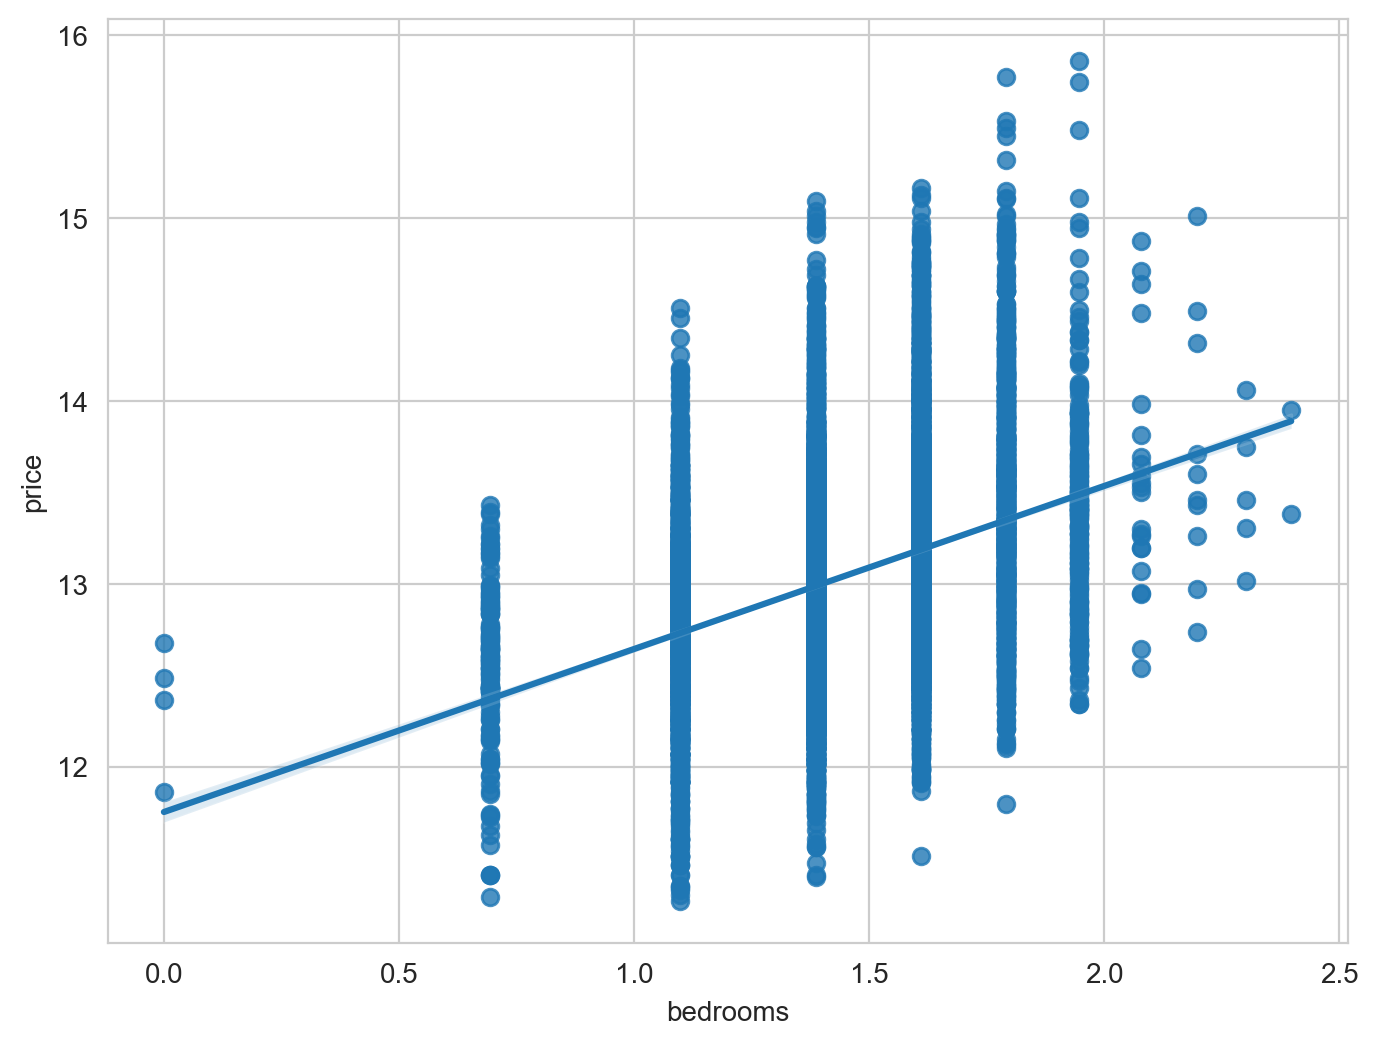

In [45]:
#'sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat'
# bathrooms
data = pd.concat([train['price'], train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
sns.set_style ('whitegrid')
fig = sns.regplot(x='bedrooms', y="price", data=data)

In [46]:
train['bedrooms'].unique()

array([1.38629436, 1.09861229, 1.79175947, 1.60943791, 1.94591015,
       0.69314718, 2.07944154, 2.30258509, 2.19722458, 0.        ,
       2.39789527])

In [47]:
get_outlier(df=train, column='view', weight=10.0)  # 이것으로는 잡을 수 없다.  정규분포 형태가 아니라서


Int64Index([   10,    16,    39,    40,    67,    76,    77,    82,    84,
               98,
            ...
            14886, 14894, 14895, 14954, 14972, 14980, 14981, 14993, 15012,
            15022],
           dtype='int64', length=1487)

In [48]:
train[train['bedrooms']==0]

id    date  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
6885    6885  201412       0.0   0.000000     7.293698      4800  1.098612   
8826    8826  201502       0.0   1.252763     7.307202      7111  1.098612   
12781  12781  201410       0.0   0.559616     5.953243    213444  0.693147   
13522  13522  201409       0.0   0.000000     5.673323     20875  0.693147   

       waterfront  view  condition  ...  sqft_basement  yr_built  \
6885          0.0   0.0          3  ...            0.0      1996   
8826          0.0   0.0          3  ...            0.0      1999   
12781         0.0   0.0          3  ...            0.0      2003   
13522         0.0   0.0          1  ...            0.0      1963   

       yr_renovated  zipcode       lat     long  sqft_living15  sqft_lot15  \
6885              0    98065  3.882110 -121.828           1060        7200   
8826              0    98065  3.882102 -121.826           1500        4675   
12781             0    98070  3.879865 -122.491           1920      224341   
13522             0    98024  3.882199 -121.888           1620       22850   

           price  is_renovated  
6885   12.367345             0  
8826   12.676079             0  
12781  12.487489             0  
13522  11.863589             0  

[4 rows x 22 columns]

In [49]:
oulier_idx_bed = [6885, 8826,12781,13522]

## (4-10) sqft_basement

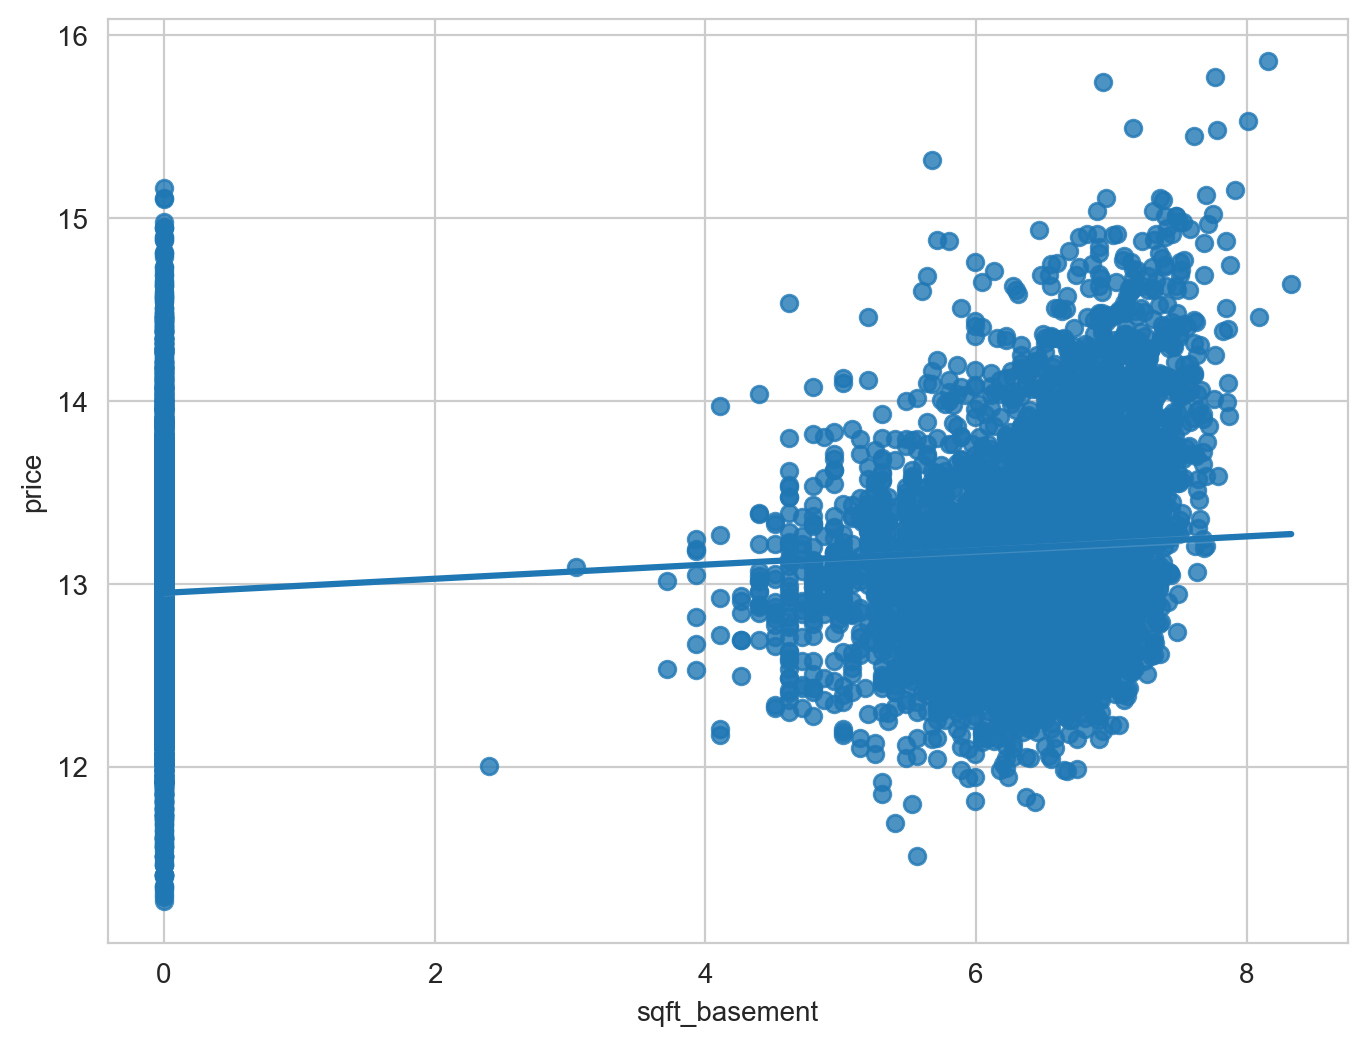

In [50]:
#'sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat'
# bathrooms
data = pd.concat([train['price'], train['sqft_basement']], axis=1)


f, ax = plt.subplots(figsize=(8, 6))
sns.set_style ('whitegrid')
fig = sns.regplot(x='sqft_basement', y="price", data=data)

In [51]:
data= data[data['sqft_basement']>0]

지하실이 있는 경우 없는 경우로 나누어 생각해야 한다. 있는 경우만 data에 담아서 분석한다.

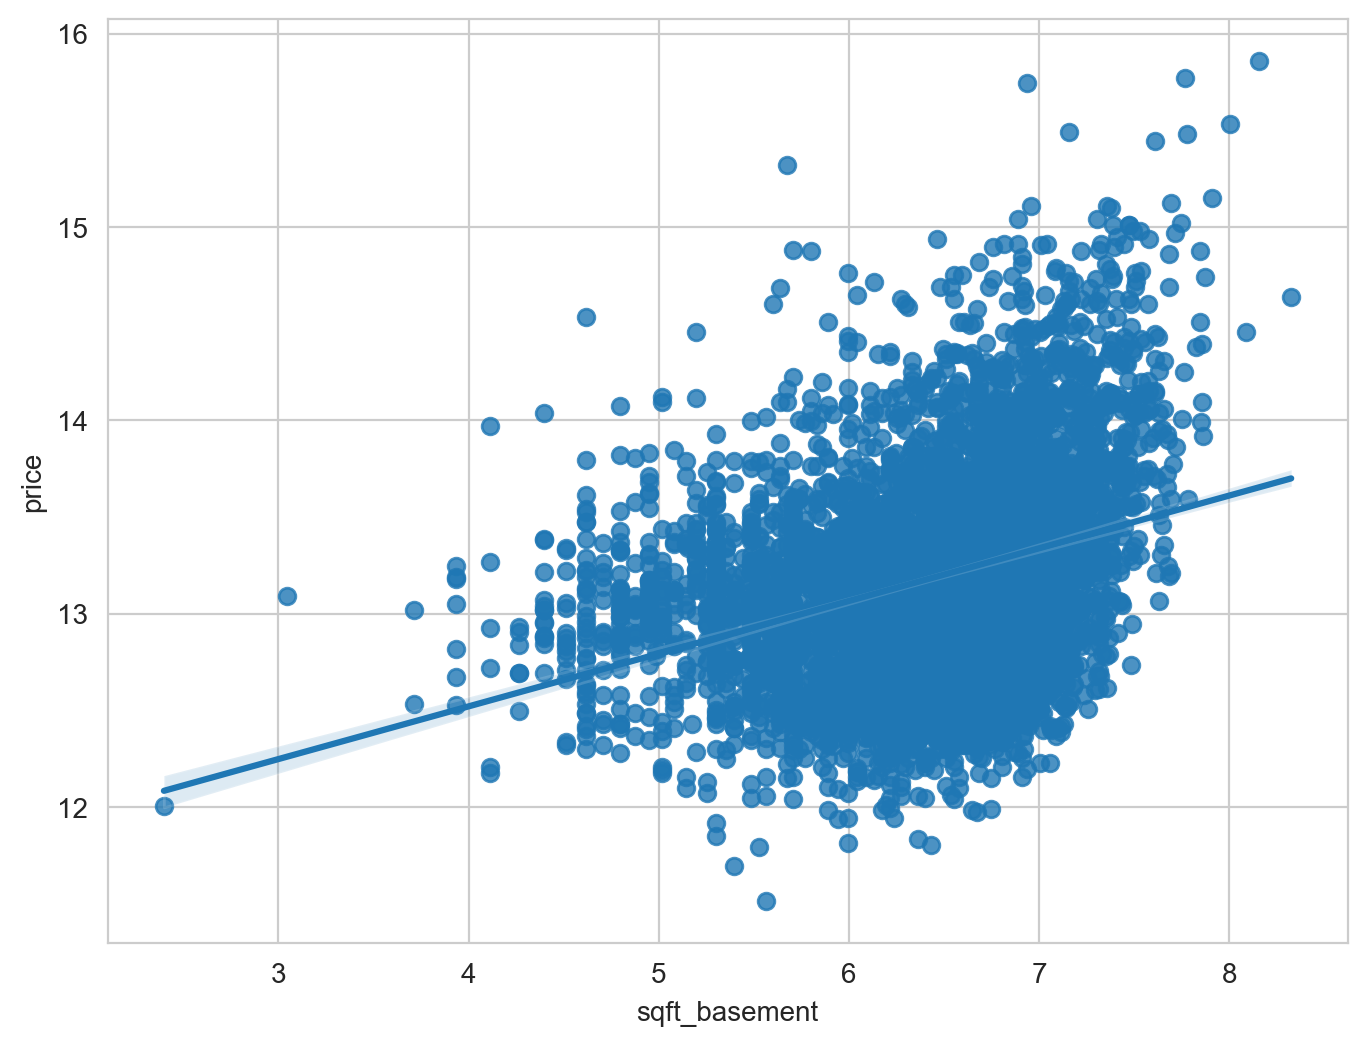

In [52]:
f, ax = plt.subplots(figsize=(8, 6))
sns.set_style ('whitegrid')
fig = sns.regplot(x='sqft_basement', y="price", data=data)

In [53]:
oulier_idx_sbase = get_outlier(df=data, column='sqft_basement', weight=4.0)
oulier_idx_sbase

Int64Index([14327], dtype='int64')

In [54]:
train.iloc[oulier_idx_sbase][['price','sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat', 'waterfront', 'floors']]

price  sqft_living     grade  sqft_above  bathrooms  view  \
14327  12.006408     6.908755  2.079442    6.898715   1.252763   0.0   

       bedrooms  sqft_basement       lat  waterfront    floors  
14327  1.098612       2.397895  3.882427         0.0  1.098612

## (4-11) lat 이상치 체크

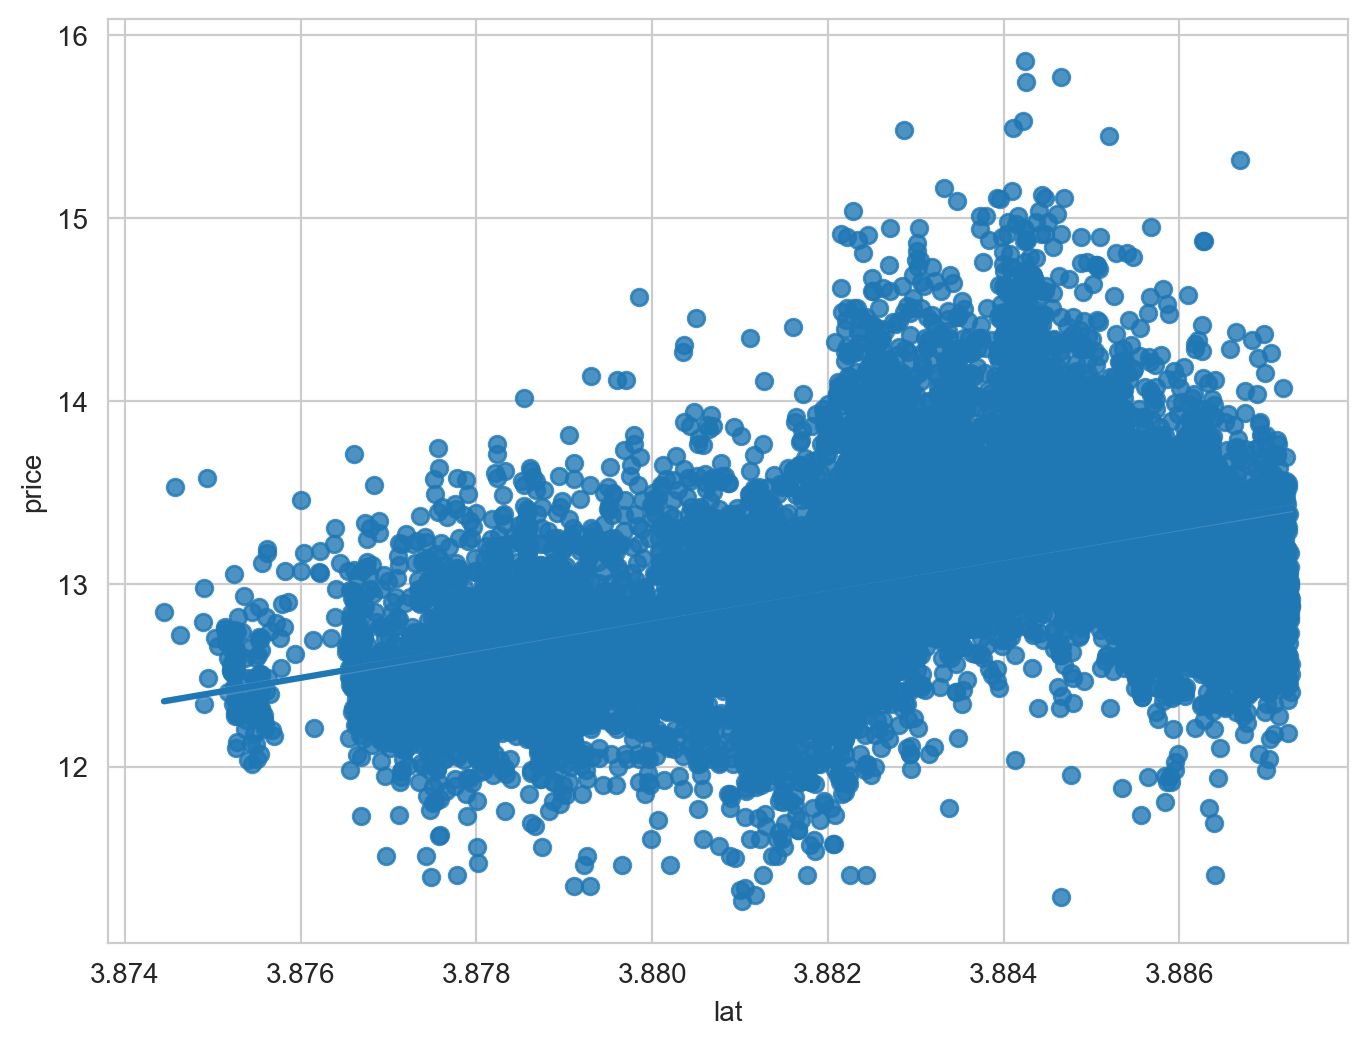

In [55]:
#'sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat'
# bathrooms
data = pd.concat([train['price'], train['lat']], axis=1)


f, ax = plt.subplots(figsize=(8, 6))
sns.set_style ('whitegrid')
fig = sns.regplot(x='lat', y="price", data=data)

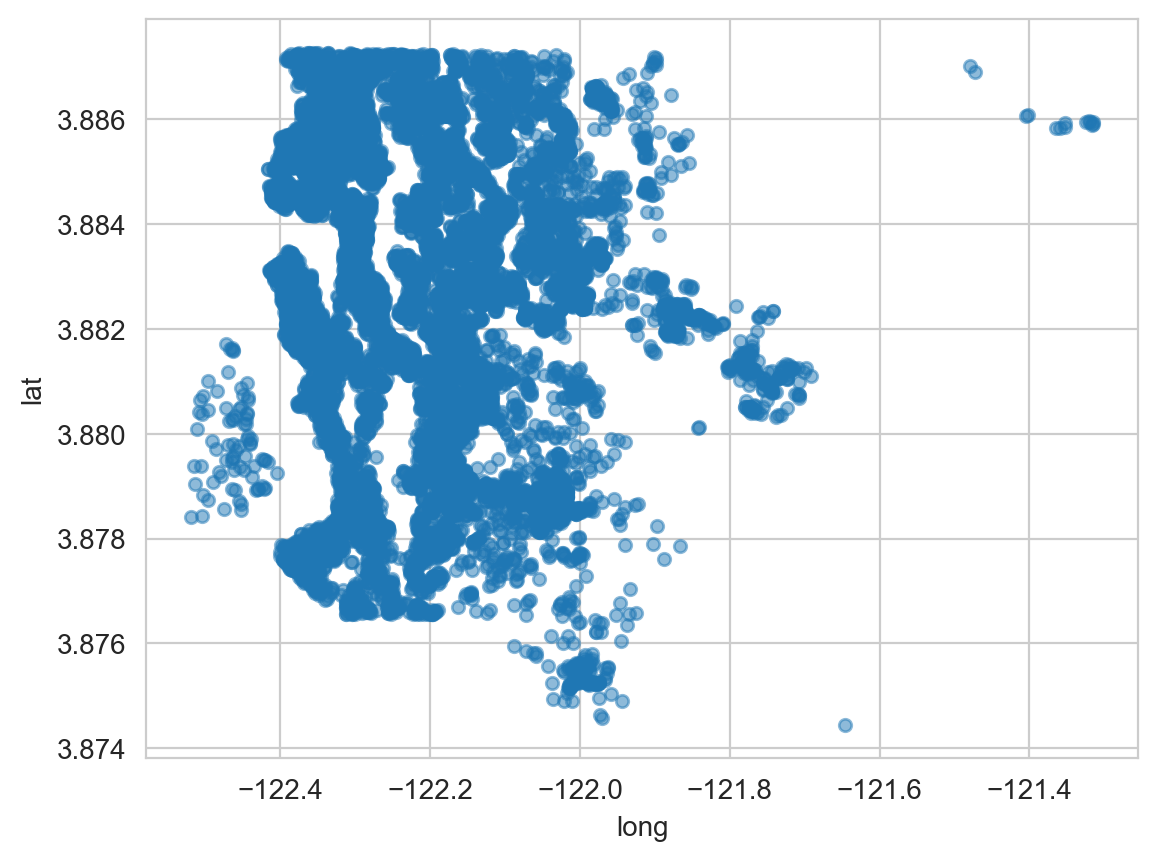

In [56]:
import matplotlib.pyplot as plt
train.plot(kind="scatter",  x="long", y="lat", alpha=0.5)
plt.show()

In [57]:
train['p/sqrt_ration'] = round(train['price']/train['sqft_living'],2)


In [58]:
train = train.reset_index(drop=True)

In [59]:
 
corr_df = train[[ 'price','date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
   'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
   'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long','p/sqrt_ration']]
corr_df.corr()



price      date  bedrooms  bathrooms  sqft_living  sqft_lot  \
price          1.000000  0.009466  0.356086   0.533806     0.677383  0.108946   
date           0.009466  1.000000 -0.001823  -0.022623    -0.021184  0.007500   
bedrooms       0.356086 -0.001823  1.000000   0.539349     0.654434  0.032578   
bathrooms      0.533806 -0.022623  0.539349   1.000000     0.766867  0.079660   
sqft_living    0.677383 -0.021184  0.654434   0.766867     1.000000  0.152306   
sqft_lot       0.108946  0.007500  0.032578   0.079660     0.152306  1.000000   
floors         0.326308 -0.020780  0.210659   0.520106     0.394396  0.005465   
waterfront     0.172580 -0.001742 -0.008997   0.063510     0.083036  0.025584   
view           0.344926  0.016484  0.077783   0.165191     0.242662  0.079820   
condition      0.042947 -0.047028  0.036453  -0.117850    -0.044443 -0.002099   
grade          0.697295 -0.023811  0.402109   0.663856     0.745830  0.109459   
sqft_above     0.591185 -0.017586  0.549797   0.695192     0.867473  0.163799   
sqft_basement  0.231982 -0.002247  0.192605   0.187497     0.277304 -0.025039   
yr_built       0.076293  0.004517  0.184313   0.527937     0.348704  0.058686   
yr_renovated   0.127533 -0.019625  0.015862   0.058250     0.058676 -0.001451   
zipcode       -0.039195 -0.000763 -0.178626  -0.224796    -0.223746 -0.127709   
lat            0.444711 -0.031694 -0.023407   0.008221     0.036544 -0.082341   
long           0.054362  0.002894  0.150666   0.240560     0.260941  0.227451   
p/sqrt_ration  0.048576  0.037995 -0.548577  -0.523622    -0.699573 -0.094269   

                 floors  waterfront      view  condition     grade  \
price          0.326308    0.172580  0.344926   0.042947  0.697295   
date          -0.020780   -0.001742  0.016484  -0.047028 -0.023811   
bedrooms       0.210659   -0.008997  0.077783   0.036453  0.402109   
bathrooms      0.520106    0.063510  0.165191  -0.117850  0.663856   
sqft_living    0.394396    0.083036  0.242662  -0.044443  0.745830   
sqft_lot       0.005465    0.025584  0.079820  -0.002099  0.109459   
floors         1.000000    0.031062  0.029048  -0.259820  0.473379   
waterfront     0.031062    1.000000  0.334761   0.011613  0.079114   
view           0.029048    0.334761  1.000000   0.047938  0.231937   
condition     -0.259820    0.011613  0.047938   1.000000 -0.141000   
grade          0.473379    0.079114  0.231937  -0.141000  1.000000   
sqft_above     0.574079    0.067640  0.155480  -0.144170  0.742321   
sqft_basement -0.267972    0.040272  0.201120   0.150613  0.073019   
yr_built       0.483546   -0.026523 -0.066454  -0.366590  0.452937   
yr_renovated   0.012769    0.104168  0.103493  -0.062342  0.029509   
zipcode       -0.067421    0.028632  0.092607   0.001106 -0.187028   
lat            0.041846   -0.014718  0.006291  -0.015986  0.114112   
long           0.141850   -0.037922 -0.077633  -0.110742  0.196896   
p/sqrt_ration -0.217047    0.051071  0.004345   0.096511 -0.336842   

               sqft_above  sqft_basement  yr_built  yr_renovated   zipcode  \
price            0.591185       0.231982  0.076293      0.127533 -0.039195   
date            -0.017586      -0.002247  0.004517     -0.019625 -0.000763   
bedrooms         0.549797       0.192605  0.184313      0.015862 -0.178626   
bathrooms        0.695192       0.187497  0.527937      0.058250 -0.224796   
sqft_living      0.867473       0.277304  0.348704      0.058676 -0.223746   
sqft_lot         0.163799      -0.025039  0.058686     -0.001451 -0.127709   
floors           0.574079      -0.267972  0.483546      0.012769 -0.067421   
waterfront       0.067640       0.040272 -0.026523      0.104168  0.028632   
view             0.155480       0.201120 -0.066454      0.103493  0.092607   
condition       -0.144170       0.150613 -0.366590     -0.062342  0.001106   
grade            0.742321       0.073019  0.452937      0.029509 -0.187028   
sqft_above       1.000000      -0.192870  0.449655      0.03

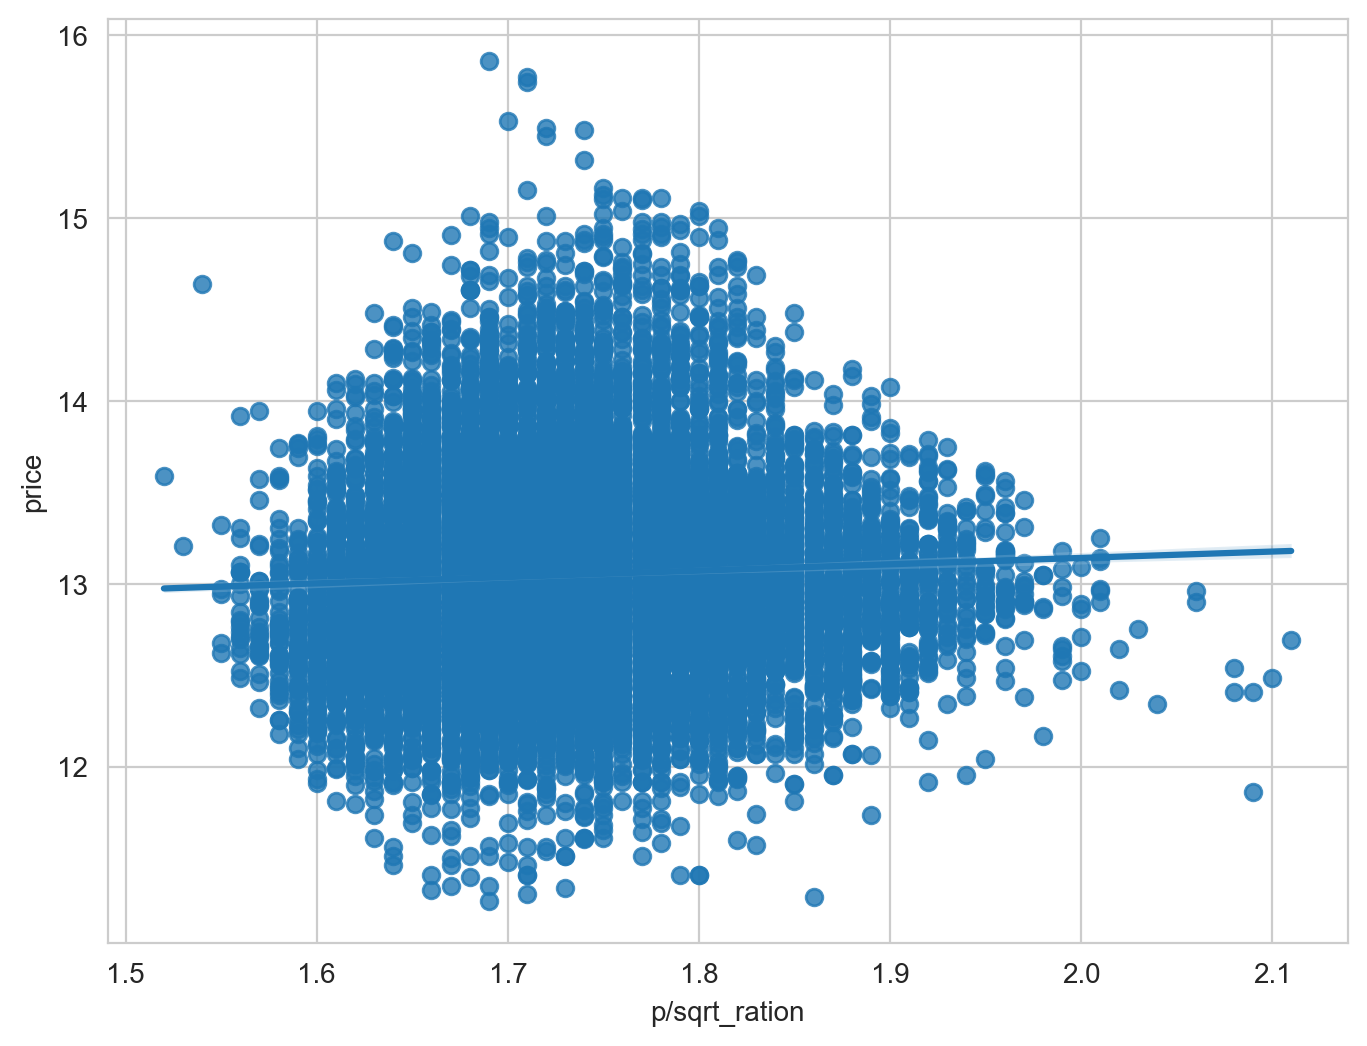

In [60]:
#'sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat'
# bathrooms
data = pd.concat([train['price'], train['p/sqrt_ration']], axis=1)


f, ax = plt.subplots(figsize=(8, 6))
sns.set_style ('whitegrid')
fig = sns.regplot(x='p/sqrt_ration', y="price", data=data)

In [61]:
get_outlier(df=data, column='p/sqrt_ration', weight=3.0)   # 이것으로는 잡을 수없어

Int64Index([631, 6042, 12781, 13522], dtype='int64')

In [62]:
# Import dependencies
import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# Configure the trace.
trace = go.Scatter3d(
    x=train['lat'],  # <-- Put your data instead
    y=train['long'],  # <-- Put your data instead
    z=train['p/sqrt_ration'],  # <-- Put your data instead
    mode='markers',
    marker={
        'size': 3,
        'opacity': 0.8,
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace]

plot_figure = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure)

<img src="https://user-images.githubusercontent.com/95423215/227939589-b6fe7621-8029-4222-b575-cb6d6fa47521.gif">
단순히 평당집값이 높다는 이유만으로 이상치를 잡을 수 없다. 왜냐하면 중심지일수록 집값이 높을 확률이 있으므로 중심지가 아닌데도 집값이 높은 경우들을 건건히 살펴 보아야 한다.    
위치적인 이유만으로도 이상건이라 하기 어렵다. 이런경우는 건건히 살펴 보아야 한다 중심지가 아니면서도 가격이 높은 이유가 있는지 살펴야 한다. 


In [63]:
oulier_idx_lat=[10082 ,10639  ]

In [64]:
# 10082 ,10639    
train.iloc[oulier_idx_lat][['price','sqft_living','grade', 'sqft_above', 'bathrooms', 'view','bedrooms', 'sqft_basement', 'lat','long', 'waterfront', 'floors']]

price  sqft_living     grade  sqft_above  bathrooms      view  \
10082  12.751303     6.293419  1.791759    6.293419   0.693147  0.000000   
10639  12.167857     6.154858  1.791759    6.154858   0.693147  1.098612   

       bedrooms  sqft_basement       lat     long  waterfront    floors  
10082  0.693147            0.0  3.887195 -122.358         0.0  0.693147  
10639  0.693147            0.0  3.875697 -121.984         0.0  0.693147

## (4-12) 이상치 제거

In [65]:
# oulier_idx_sl 10 
# oulier_idx_grade 3
# oulier_idx_sa 35
# oulier_idx_bath 8
# oulier_idx_view 5
# oulier_idx_bed 4
# oulier_idx_sbase 11
# oulier_idx_lat 16


# 삭제한 train의 index set로 모아서 중복을 없앤다. 

delete_set = set.union(set(oulier_idx_sl), set(oulier_idx_grade), set(oulier_idx_sa),
                      set(oulier_idx_bath), set(oulier_idx_view), set(oulier_idx_bed),
                       set(oulier_idx_sbase), set(oulier_idx_lat)  )

len(delete_set)

16

In [66]:
train.head()

id    date  bedrooms  bathrooms  sqft_living  sqft_lot    floors  \
0   0  201410  1.386294   0.693147     7.074117      5650  0.693147   
1   1  201502  1.098612   0.693147     6.647688     10000  0.693147   
2   2  201502  1.386294   1.098612     7.427144      8080  0.693147   
3   3  201406  1.386294   1.178655     7.447751      6819  1.098612   
4   4  201501  1.386294   0.916291     6.966967      9711  0.693147   

   waterfront  view  condition  ...  yr_built  yr_renovated  zipcode  \
0         0.0   0.0          3  ...      1955             0    98178   
1         0.0   0.0          3  ...      1933             0    98028   
2         0.0   0.0          3  ...      1987             0    98074   
3         0.0   0.0          3  ...      1995             0    98003   
4         0.0   0.0          3  ...      1963             0    98198   

        lat     long  sqft_living15  sqft_lot15      price  is_renovated  \
0  3.881795 -122.257           1340        5650  12.309987             0   
1  3.886457 -122.233           2720        8062  12.100718             0   
2  3.883969 -122.045           1800        7503  13.142168             0   
3  3.877632 -122.327           2238        6819  12.458779             0   
4  3.879696 -122.315           1650        9711  12.583999             0   

   p/sqrt_ration  
0           1.74  
1           1.82  
2           1.77  
3           1.67  
4           1.81  

[5 rows x 23 columns]

In [67]:
train.drop(delete_set, inplace=True)

In [68]:
len(train)

15019

# 5.모델 성능 점검
* Cross Validation 
* RMSE 모델 성능 검증


## (5-1) 데이타 준비 확인

In [69]:
y_log = train['price']
del train['price']

In [70]:

test=test[['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
        'waterfront', 'view', 'condition', 'grade', 'sqft_above',
        'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
        'sqft_living15', 'sqft_lot15', 'is_renovated']]

In [71]:
train.shape, test.shape, y_log.shape

((15019, 22), (6468, 20), (15019,))

In [72]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

def get_scores(models, train, y):
    # 답안 작성
    df = {}

    for model in models:
        # 모델 이름 획득
        model_name = model.__class__.__name__

        # train, test 데이터셋 분리 - 여기에도 random_state를 고정합니다. 
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)

        # 모델 학습
        model.fit(X_train, y_train)
        
        # 예측
        y_pred = model.predict(X_test)

        # 예측 결과의 rmse값 저장
        df[model_name] = rmse(y_test, y_pred)
        
        # data frame에 저장
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return score_df

def get_cv_score(models,train,y):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m, X=train.values, y=y, cv=kfold))
        print(f"Model: {m.__class__.__name__}, CV score:{CV_score:.4f}")

## (5-2) Cross Validation 

In [73]:
random_state=100 

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
#rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm]

get_cv_score(models,train,y_log)


Model: GradientBoostingRegressor, CV score:0.9742
Model: XGBRegressor, CV score:0.9925
Model: LGBMRegressor, CV score:0.9941


## (5-3)RMSE 모델 성능 검증

In [74]:
get_scores(models, train, y_log)

RMSE
GradientBoostingRegressor  56114.875528
LGBMRegressor              36539.742759
XGBRegressor               34867.311888

# 6. 하이퍼 파라미터 세팅

In [75]:
from sklearn.model_selection import GridSearchCV

def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    # GridSearchCV 모델로 초기화
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', \
                              cv=5, verbose=verbose, n_jobs=n_jobs)
    # 모델 fitting
    grid_model.fit(train, y)

    # 결과값 저장
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    # 데이터 프레임 생성
    results = pd.DataFrame(params)
    results['score'] = score
    
    # RMSLE 값 계산 후 정렬
    results['RMSLE'] = np.sqrt(-1 * results['score'])
    results = results.sort_values('RMSLE')

    return results 

def AveragingBlending(models, x, y, test):
    
    for m in models : 
        m.fit(x.values, y)
        #m['model'].fit(x.values, y)
        
    predictions = np.column_stack([
        m.predict(test.values) for m in models
        #m['model'].predict(test.values) for m in models
    ])
    return np.mean(predictions, axis=1)

## (6-1) 최적의 파라미터 세팅

In [76]:
train = train[[ 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'is_renovated']]

## (6-2) LGBMRegressor 하이퍼 파라미터 세팅

In [77]:
random_state=100 
param_lightgbm = { 
    "learning_rate" : [0.07],
    "max_depth" : [10],
    "n_estimators" : [300]
}
models = [ xgboost, lightgbm]

lightgbm = LGBMRegressor(random_state=random_state)
my_GridSearch(lightgbm, train, y_log, param_lightgbm, verbose=2, n_jobs=-1)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


learning_rate  max_depth  n_estimators     score     RMSLE
0           0.07         10           300 -0.025836  0.160736

## (6-3) XGBRegressor 하이퍼 파라미터 세팅

In [78]:
random_state=100 
param_xgboost = {
    "learning_rate" : [0.1],
    "max_depth": [9],
    "min_child_weight" : [19],
    "n_estimators": [100]
}

xgboost = XGBRegressor(random_state=random_state)
my_GridSearch(xgboost, train, y_log, param_xgboost, verbose=2, n_jobs=-1)


Fitting 5 folds for each of 1 candidates, totalling 5 fits


learning_rate  max_depth  min_child_weight  n_estimators     score  \
0            0.1          9                19           100 -0.026187   

      RMSLE  
0  0.161824

* 컬럼의 수를 줄이는 것은 도움이 안되었다. 가장 영향력이 적은  'long'를 뺐는데도 0.1628->0.1684
* 나머지데이타에 대한 스케일링이 도움이 안되었다. 0.1628->0.1684


# 7. 훈련 및 예측 Blending

In [79]:
lightgbm.fit(train,y_log)


LGBMRegressor(random_state=100)

In [80]:
pred_lightgbm=lightgbm.predict(test)

In [81]:
xgboost.fit(train,y_log)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=100,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [82]:
pred_xgboost =xgboost.predict(test)

In [83]:
prediction = 0.4*np.expm1(pred_xgboost) + 0.6*np.expm1(pred_lightgbm)

# 8. 파일출력 및 제출

In [84]:
def save_submission(prediction, model_name, rmsle=None):

    data_dir = os.getenv("HOMEPATH") + "/_Python/Exploration/data/housing/"
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, model_name, rmsle)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))

In [85]:
save_submission(prediction,'lightgbm')

\Users\peunj/_Python/Exploration/data/housing//submission_lightgbm_RMSLE_None.csv saved!


<img src="https://user-images.githubusercontent.com/95423215/227949248-273d8451-70f0-4da7-9ba9-c9fd83f51d0d.png"/>

# 회고

* 막막함으로 시작해 당혹감으로 끝났던 프로젝트였다.
* 처음 하이퍼 파라미터를 세팅해서 최적의 파라미터를 찾는 것을 시작했다. 한꺼번에 후보 파라미터들을 선택해서 찾는 방법도 있었지만, 장시간 기다리는 것을 선호하지 않아.짦은 템포로 범위를 줄여가며 탐색하였다. 베스트 파라미터를 선정했다고 생각하고 데이타 선처리에 들어갔다.
* 결측데이타가 없다는 것을 확인하고 이상치 데이타를 찾기 위해 각 컬럼들 별로 찾아야 했다. 
* Target price에 영향을 많이 주는 Feature를 찾기 위해 상관계수는 전체 컬럼에 대해 먼저 진행했다. (3-1) 모든 feature 상관계수
* 상관계수 가운데서 영향도가 높은 feature 10를 기준으롤 뽑아 Top 10을 뽑았다. 
* 상관계수를 뽑는데도 Normalization 하기 전에 뽑은 상관계수(1등 sqft_living)와 Normalization한 후에 상관계수(1등 grade)가 달랐다.
* 이상치(outlier)를 찾기 위해 전에 배웠던 IQR을 이용해 outlier를 찾았다. 그러려면 컬럼들의 분포가 정규분포 여야 의미가 있어서    각각의 이상치를 찾기 전에 먼저 log scaling으로 normalize를 해줬다. 
* 이상치를 찾는 과정에서 처음에 normalize를 하지 않고 scatter 그래프를 보면서 이상치를 눈으로 찾았다. 하지만, normalize를 하고 났더니 그것이 이상치에 잡히지 않았다. 내가 잡은 이상치가 이상치가 아니란 말인가? 그럼 normalize를 한다는 의미는 무엇인가?
* 한참을 삽질을 하고서 알았다. 아하~!  Normalize를 한다는 뜻은  벡터들의 중앙값, 평균을 중심으로 놓고 보고 싶다는 뜻이었다.
* vector space 안에서 흩뿌려져있는 feature들은 보는 관점에 따라 다르게 보일 수 있고, 함수를 써서 transform 변환이 가능하데, 이것은 공간 자체를 변형시키는 (함수를 통해)것이다. 그래서 Normalize를 한다는 것은 평균을 중심으로 놓고 보는 관점이다. 
* 로그함수를 통해 normalize를 한다는 것은 로그함수의 특징상 작은 차이는 크게 보이게 하고  큰 차이는 작게 보이게 해서 한쪽으로 쏠려있는 데이타를 펼쳐서 잘 보이게 하는 효과가 있다. 
* 불필요한 컬럼이라 생각해 long 컬럼을 삭제했는데, RMSLE 오히려 안좋아졌다.
* 이번 프로젝트에서 Normalization과 이상치에 대해서 조금더 명확히 알게 되었다. 
* cv score에 대해서, 하이퍼 파라미터 세팅에 대해서 chatGPT를 활용하는 것이 도움이 되었다. 
* 하다보니 이상치를 어느정도까지 삭제해야 적절한지에 대한 기준이 명확하지 않다는 생각이 들어서 그 부분을 다음에 더 익혀보고 싶다.  
* 내가 손댈 수록 베이스라인도 멀어지며 점점 않좋아지는 상황이라 당혹스러움이 들지만 시간내에 마치게 되서 다행이다. 휴~.


## 참고자료

#### Question Expoloation With ChatGPT   

[1] <a href="https://github.com/billygogo/aiffel_exploration/blob/main/aiffel_exploration/reference/CV_vs_RMSE.ipynb" target="_blank">CV vs RMSE </a><br>
[2] <a href="https://github.com/billygogo/aiffel_exploration/blob/main/aiffel_exploration/reference/HyperParameter.ipynb" target="_blank">HyperParameter</a><br>
[3]<a href="https://github.com/billygogo/aiffel_exploration/blob/main/aiffel_exploration/reference/Scaling%20and%20Normalization.ipynb" target="_blank"> Scaling and Normalization/a>